## Stochastic RNN implementation
#####  - following Fraccaro et al. (2016; arXiv:1605.07571v2)
#####  - author: Xinyue Sheng (30/07/2021)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


notes and links: 

http://louistiao.me/listings/keras/.ipynb_checkpoints/use-negative-log-likelihoods-of-tensorflow-distributions-as-keras-losses-checkpoint.ipynb.html


https://machinelearningmastery.com/handle-missing-timesteps-sequence-prediction-problems-python/


In [ ]:
!pip install eztao

     |████████████████████████████████| 10.3 MB 8.6 MB/s 
     |████████████████████████████████| 296 kB 29.1 MB/s 
     |████████████████████████████████| 28.5 MB 54 kB/s 
     |████████████████████████████████| 45 kB 3.4 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:

# setup
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# add RNN-related API
from tensorflow.keras.layers import (Input, Dense, TimeDistributed, LSTM, GRU, Dropout, concatenate, Lambda, Masking, Embedding,
                          Flatten, RepeatVector, Bidirectional)
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from keras import backend as K
# from keras import objectives
from keras import losses
# from keras.objectives import binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the TensorBoard notebook extension
%load_ext tensorboard

import datetime
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [ ]:
# seasonal dataset
import json
import os
import math
import eztao
from eztao.carma import DRW_term,DHO_term, CARMA_term
from eztao.ts import gpSimRand
from eztao.ts import drw_fit
from eztao.ts import gpSimFull, gpSimByTime
from eztao.ts.carma_fit import sample_carma

import matplotlib.pyplot as plt
import math
import numpy as np

def season_cadence(t, y, yerr, season_len = 60, gap_len = 30):
  nt, ny, nyerr = [], [], []
  itr = int((t[-1] - t[0])/(season_len + gap_len))
  n = 0
  m = 0
  while m < itr:
    nt.extend(t[n:(n+season_len)])
    nt.extend([0]*gap_len)
    ny.extend(y[n:(n+season_len)])
    ny.extend([0]*gap_len)
    nyerr.extend(yerr[n:(n+season_len)])
    nyerr.extend([0]*gap_len)
    n += (season_len + gap_len)
    m += 1

  if len(t) - n <= season_len:
    nt.extend(t[n:])
    ny.extend(y[n:])
    nyerr.extend(yerr[n:])
  else:
    nt.extend(t[n:(n+season_len)])
    ny.extend(y[n:(n+season_len)])
    nyerr.extend(yerr[n:(n+season_len)])
    n += season_len
    nt.extend([0]*(len(t) - n))
    ny.extend([0]*(len(t) - n))
    nyerr.extend([0]*(len(t) - n))
  return nt, ny, nyerr 

def normalization(data):
  return (data - np.mean(data))/np.std(data)

def preprocess_add_zeros(miss_mjd, miss_y, miss_yerr, full_mjd):
  new_miss_mjd = full_mjd.copy()
  new_miss_y = np.zeros(len(new_miss_mjd))
  new_miss_yerr = np.zeros(len(new_miss_mjd))

  n = 0
  for i in new_miss_mjd:
    if i in miss_mjd:
      i_idx = np.where(miss_mjd == i)
      new_miss_y[n] = miss_y[i_idx[0][0]] 
      new_miss_yerr[n] = miss_yerr[i_idx[0][0]]
    n +=1
  # miss_sequence = [[t, y, yerr] for t, y, yerr in zip(new_miss_mjd, new_miss_y, new_miss_yerr)]
  return new_miss_mjd, new_miss_y, new_miss_yerr



input_dataset = list()
target_dataset = list()
# scaler = MinMaxScaler()
# 'drw/', 'over/','under/', 
path_list = ['drw/']

for carma_path in path_list:
  filepath = '/content/drive/Othercomputers/My MacBook Pro/SRNN_dataset/lsst_obs/'+carma_path
  print(carma_path, 'start...')
  obj_paths = os.listdir(filepath)

  for obj in obj_paths[:100]:
    f = open(filepath+obj, 'r')
    obj_info = json.load(f)
    for cad in obj_info.keys():
      obj_cs = obj_info[cad]
      for band in ['u','g','r','i','z','y']:
        full_mjd = np.around(obj_cs[band]['full']['mjd'], decimals=0)# set decimal to 0
        full_y = obj_cs[band]['full']['y']
        real_mean = np.mean(full_y)
        full_y -= real_mean
        full_sequence = [[t, y] for t, y in zip(full_mjd, full_y)]
        st, sy, syerr = season_cadence(full_mjd, full_y, np.zeros(len(full_y)), season_len = 30, gap_len = 120)
        season_sequence = [[t, y, yerr] for t, y, yerr in zip(st, sy, syerr)]
        # add dense light curve to the training process
        input_dataset.append(season_sequence)
        target_dataset.append(full_sequence)



input_dataset, target_dataset = np.array(input_dataset), np.array(target_dataset)

print(input_dataset.shape,target_dataset.shape)

  


  







drw/ start...
(3000, 3650, 3) (3000, 3650, 2)


In [ ]:
# for non-identical dataset 


# load json files from google drive
import json
import os
# from sklearn.preprocessing import MinMaxScaler

def normalization(data):
  return (data - np.mean(data))/np.std(data)

def preprocess_add_zeros(miss_mjd, miss_y, miss_yerr, full_mjd):
  new_miss_mjd = full_mjd.copy()
  new_miss_y = np.zeros(len(new_miss_mjd))
  new_miss_yerr = np.zeros(len(new_miss_mjd))

  n = 0
  for i in new_miss_mjd:
    if i in miss_mjd:
      i_idx = np.where(miss_mjd == i)
      new_miss_y[n] = miss_y[i_idx[0][0]] 
      new_miss_yerr[n] = miss_yerr[i_idx[0][0]]
    n +=1
  # miss_sequence = [[t, y, yerr] for t, y, yerr in zip(new_miss_mjd, new_miss_y, new_miss_yerr)]
  return new_miss_mjd, new_miss_y, new_miss_yerr

def add_straight_lines(miss_mjd, miss_y, miss_yerr, full_mjd):
   # add straight line between distant observations
  miss_mjd -= miss_mjd[0]
  diff_miss_mjd = np.diff(miss_mjd)
  diff_miss_y = np.diff(miss_y)
  new_miss_y = np.zeros(len(full_mjd))
  new_miss_yerr = np.zeros(len(full_mjd))
  new_miss_y[0] = miss_y[0]
  new_miss_yerr[0] = miss_yerr[0]

  n = 0
  m = 1
  while n < len(diff_miss_mjd):
    if int(diff_miss_mjd[n]) == 1:
      new_miss_y[m] = new_miss_y[m-1] + diff_miss_y[n]
      new_miss_yerr[m] = miss_yerr[n+1]
      m += 1
    else:
      divide_y = diff_miss_y[n]/int(diff_miss_mjd[n])
      for delta_t in np.arange(int(diff_miss_mjd[n])):
        new_miss_y[m+delta_t] = new_miss_y[m+delta_t-1] + divide_y
        new_miss_yerr[m+delta_t] = new_miss_yerr[m+delta_t-1]
      m += int(diff_miss_mjd[n])
    n += 1

  # miss_sequence = [[t, y, yerr] for t, y, yerr in zip(full_mjd, new_miss_y, new_miss_yerr)]
  return full_mjd, new_miss_y, new_miss_yerr


input_dataset = list()
target_dataset = list()
# scaler = MinMaxScaler()
# 'drw/', 'over/','under/', 
path_list = ['drw/']

for carma_path in path_list:
  filepath = '/content/drive/Othercomputers/My MacBook Pro/SRNN_dataset/lsst_obs/'+carma_path
  print(carma_path, 'start...')
  obj_paths = os.listdir(filepath)

  for obj in obj_paths[:100]:
    f = open(filepath+obj, 'r')
    obj_info = json.load(f)
    for cad in obj_info.keys():
      obj_cs = obj_info[cad]
      for band in ['u','g','r','i','z','y']:
        full_mjd = np.around(obj_cs[band]['full']['mjd'], decimals=0)# set decimal to 0
        full_y = obj_cs[band]['full']['y']
        real_mean = np.mean(full_y)
        full_y -= real_mean

        # miss_mjd = np.around(obj_cs[band]['10yrs']['mjd'], decimals=0)
        # miss_y = obj_cs[band]['10yrs']['y']
        # miss_y -= real_mean
        # miss_yerr = obj_cs[band]['10yrs']['yerr']
       
        # new_miss_mjd, new_miss_y, new_miss_yerr = preprocess_add_zeros(miss_mjd, miss_y, miss_yerr, full_mjd)


        # miss_sequence = [[t, y, yerr] for t, y, yerr in zip(new_miss_mjd, new_miss_y, new_miss_yerr)]
        full_sequence = [[t, y, yerr] for t, y, yerr in zip(full_mjd, full_y, np.zeros(len(full_mjd)))]

        # input_dataset.append(miss_sequence)
        # target_dataset.append(full_sequence)

        # add dense light curve to the training process
        input_dataset.append(full_sequence)
        target_dataset.append(full_sequence)



input_dataset, target_dataset = np.array(input_dataset), np.array(target_dataset)

print(input_dataset.shape,target_dataset.shape)




drw/ start...
(3000, 3650, 3) (3000, 3650, 3)


In [ ]:
# for identical dataset 


# load json files from google drive
import json
import os
# from sklearn.preprocessing import MinMaxScaler

def normalization(data):
  return (data - np.mean(data))/np.std(data)

def preprocess_add_zeros(miss_mjd, miss_y, miss_yerr, full_mjd):
  new_miss_mjd = full_mjd.copy()
  new_miss_y = np.zeros(len(new_miss_mjd))
  new_miss_yerr = np.zeros(len(new_miss_mjd))

  n = 0
  for i in new_miss_mjd:
    if i in miss_mjd:
      i_idx = np.where(miss_mjd == i)
      new_miss_y[n] = miss_y[i_idx[0][0]] 
      new_miss_yerr[n] = miss_yerr[i_idx[0][0]]
    n +=1
  # miss_sequence = [[t, y, yerr] for t, y, yerr in zip(new_miss_mjd, new_miss_y, new_miss_yerr)]
  return new_miss_mjd, new_miss_y, new_miss_yerr

def add_straight_lines(miss_mjd, miss_y, miss_yerr, full_mjd):
   # add straight line between distant observations
  miss_mjd -= miss_mjd[0]
  diff_miss_mjd = np.diff(miss_mjd)
  diff_miss_y = np.diff(miss_y)
  new_miss_y = np.zeros(len(full_mjd))
  new_miss_yerr = np.zeros(len(full_mjd))
  new_miss_y[0] = miss_y[0]
  new_miss_yerr[0] = miss_yerr[0]
  n = 0
  m = 1
  while n < len(diff_miss_mjd):
    if int(diff_miss_mjd[n]) == 1:
      new_miss_y[m] = new_miss_y[m-1] + diff_miss_y[n]
      new_miss_yerr[m] = miss_yerr[n+1]
      m += 1
    else:
      divide_y = diff_miss_y[n]/int(diff_miss_mjd[n])
      for delta_t in np.arange(int(diff_miss_mjd[n])):
        new_miss_y[m+delta_t] = new_miss_y[m+delta_t-1] + divide_y
        new_miss_yerr[m+delta_t] = new_miss_yerr[m+delta_t-1]
      m += int(diff_miss_mjd[n])
    n += 1

  # miss_sequence = [[t, y, yerr] for t, y, yerr in zip(full_mjd, new_miss_y, new_miss_yerr)]
  return full_mjd, new_miss_y, new_miss_yerr




input_dataset = list()
target_dataset = list()
# scaler = MinMaxScaler()
# 'drw/', 'over/','under/', 
path_list = ['under/']

id_dict = {}
n = 0

for carma_path in path_list:
  filepath = '/content/drive/Othercomputers/My MacBook Pro/SRNN_dataset/lsst_obs_redshift/'+carma_path
  print(carma_path, 'start...')
  obj_paths = os.listdir(filepath)

  for obj in obj_paths[100:200]:
    f = open(filepath+obj, 'r')
    obj_info = json.load(f)
    for band in ['u','g','r','i','z','y']:
      obj_band = obj_info[band]
      for cad in obj_band.keys():
        obj_cs = obj_band[cad]
        if cad == 'full':
          full_mjd = np.around(obj_cs['mjd'], decimals=0)# set decimal to 0
          full_y = obj_cs['y']
          real_mean = np.mean(full_y)
          full_y -= real_mean
        else:
          miss_mjd = np.around(obj_cs['mjd'], decimals=0)
          miss_y = obj_cs['y']
          miss_y -= real_mean
          miss_yerr = obj_cs['yerr']  
          new_miss_mjd, new_miss_y, new_miss_yerr = preprocess_add_zeros(miss_mjd, miss_y, miss_yerr, full_mjd)
          miss_sequence = [[t, y, yerr] for t, y, yerr in zip(new_miss_mjd, new_miss_y, new_miss_yerr)]
          full_sequence = [[t, y, yerr] for t, y, yerr in zip(full_mjd, full_y, np.zeros(len(full_mjd)))]
          input_dataset.append(miss_sequence)
          target_dataset.append(full_sequence)

          id_dict[n] = obj
          n += 1

        # add dense light curve to the training process
        # input_dataset.append(full_sequence)
        # target_dataset.append(full_sequence)



input_dataset, target_dataset = np.array(input_dataset), np.array(target_dataset)

print(input_dataset.shape,target_dataset.shape)




under/ start...
(3000, 3650, 3) (3000, 3650, 3)


In [ ]:
# generate many drw light curves from eztao
# import eztao
# from eztao.carma import DRW_term,DHO_term, CARMA_term
# from eztao.ts import drw_fit
# from celerite import GP
# from eztao.ts import gpSimFull, gpSimByTime,gpSimRand
# from eztao.ts.carma_fit import sample_carma
# from sklearn.preprocessing import MinMaxScaler
from math import ceil

def downsampeLC(cadence_mjds, t, y, yerr):
    mjds_round3 = np.around(cadence_mjds, decimals = 0)
    t_round3 = np.around(t, decimals = 0)
    downsample_mjds, t_idx, c_idx = np.intersect1d(t_round3, mjds_round3,return_indices=True)
    y[t_idx] = np.mean(y)
    yerr[t_idx] = np.mean(yerr)
    return t, y, yerr


def add_regular_seasons(season = 60, gap = 120, npts = 3650):
  cadence_mjds = []
  m = 0
  while m < (npts-gap):
    cadence_mjds += list(np.arange(m, m+gap))
    m += season+gap
  cadence_mjds = np.array(cadence_mjds)
  return cadence_mjds

def predict_steps(pred_steps = 365, npts = 3650):
  return np.arange(npts-pred_steps+1, npts+1)


cadence_mjds = add_regular_seasons(season = 30, gap = 200, npts = 3650)


input_dataset = list()
target_dataset = list()

path_list = ['drw/', 'over/','under/']

for carma_path in path_list:
  filepath = '/content/drive/Othercomputers/My MacBook Pro/SRNN_dataset/lsst_obs_identical/'+carma_path
  print(carma_path, 'start...')
  obj_paths = os.listdir(filepath)

  for obj in obj_paths:
    f = open(filepath+obj, 'r')
    obj_info = json.load(f)
    for band in ['u','g','r','i','z','y']:
      obj_band = obj_info[band]
      obj_cs = obj_band['full']
      full_mjd = np.around(obj_cs['mjd'], decimals=0)# set decimal to 0
      full_y = obj_cs['y']
      real_mean = np.mean(full_y)
      full_y -= real_mean
      full_yerr = np.zeros(len(full_mjd))
      t_m, y_m, yerr_m = full_mjd.copy(), full_y.copy(), full_yerr.copy()
      t_m, y_m, yerr_m = downsampeLC(cadence_mjds, t_m, y_m, yerr_m)

      # new_miss_mjd, new_miss_y, new_miss_yerr = preprocess_add_zeros(miss_mjd, miss_y, miss_yerr, full_mjd)
      miss_sequence = [[t, y, yerr] for t, y, yerr in zip(t_m, y_m, yerr_m)]
      full_sequence = [[t, y, yerr] for t, y, yerr in zip(full_mjd, full_y, np.zeros(len(full_mjd)))]
      input_dataset.append(miss_sequence)
      target_dataset.append(full_sequence)

        # add dense light curve to the training process
        # input_dataset.append(full_sequence)
        # target_dataset.append(full_sequence)



input_dataset, target_dataset = np.array(input_dataset), np.array(target_dataset)

print(input_dataset.shape,target_dataset.shape)

from math import ceil
samples = target_dataset.shape[0]

# shuffle train and test sets

idx = np.arange(target_dataset.shape[0])
np.random.shuffle(idx)
input_dataset = input_dataset[idx]
target_dataset = target_dataset[idx]

# split to train nd test sets
train_ratio = 0.8
train_x = input_dataset[:ceil(train_ratio*samples),:,[1]]
train_y = target_dataset[:ceil(train_ratio*samples),:,[1]]

test_x = input_dataset[ceil(train_ratio*samples):,:,[1]]
test_y = target_dataset[ceil(train_ratio*samples):,:,[1]]

# del input_dataset, target_dataset

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

drw/ start...
over/ start...
under/ start...
(1800, 3650, 3) (1800, 3650, 3)
(1440, 3650, 1) (1440, 3650, 1) (360, 3650, 1) (360, 3650, 1)


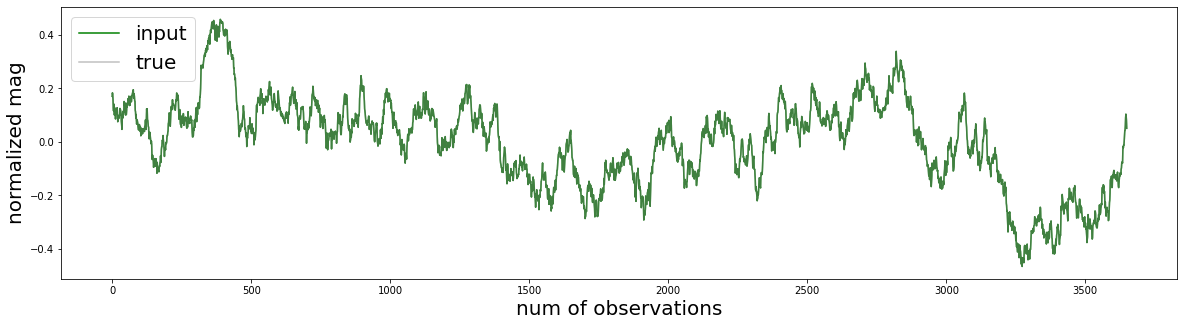

In [ ]:
import matplotlib.pyplot as plt

n = np.random.randint(0, input_dataset.shape[0])
# print(id_dict[n])

orig_lc = [0]
orig_diff_lc = input_dataset[n,:,1]
start = 0
for i in orig_diff_lc:
  start += i
  orig_lc.append(start)


true_diff_lc = target_dataset[n,:,1]

true_lc = [0]
start = 0
for i in true_diff_lc:
  start += i
  true_lc.append(start)


plt.figure(figsize = (20,5))

plt.plot(np.arange(len(orig_diff_lc)), orig_diff_lc, c = 'green', label = 'input')
plt.plot(np.arange(len(true_diff_lc)), true_diff_lc, c = 'grey', alpha = 0.5, label = 'true')


plt.legend(loc = 'upper left',fontsize = 20)
plt.xlabel('num of observations', fontsize = 20)
plt.ylabel('normalized mag', fontsize = 20)
plt.show()

In [ ]:
from math import ceil
samples = target_dataset.shape[0]

# shuffle train and test sets

idx = np.arange(target_dataset.shape[0])
np.random.shuffle(idx)
input_dataset = input_dataset[idx]
target_dataset = target_dataset[idx]

# split to train nd test sets
train_ratio = 0.8
train_x = input_dataset[:ceil(train_ratio*samples),:,[1,2]]
train_y = target_dataset[:ceil(train_ratio*samples),:,[1]]

test_x = input_dataset[ceil(train_ratio*samples):,:,[1,2]]
test_y = target_dataset[ceil(train_ratio*samples):,:,[1]]

del input_dataset, target_dataset

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(2400, 3650, 2) (2400, 3650, 1) (600, 3650, 2) (600, 3650, 1)


In [ ]:
import eztao
from eztao.carma import DRW_term,DHO_term, CARMA_term
from eztao.ts import drw_fit
from celerite import GP
from eztao.ts import gpSimFull, gpSimByTime,gpSimRand
from eztao.ts.carma_fit import sample_carma
from sklearn.preprocessing import MinMaxScaler
from math import ceil


##### Above is just for single light curve, however, our goal is to predict thousands of light cruves future observations. Below is the code for generating N samples DRW light curves with varying amplitude(amp) and timescales(tau). 

In [ ]:
timestep = train_x.shape[1]
features = 1
pred_timestep = train_y.shape[1]
pred_features = 1

num_neutron = 32
z_neutron = 32




# create a sampling layer for latent distribution z 
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        timestep = z_mean.shape[1]
        dim = z_mean.shape[2]
        epsilon = K.random_normal(shape=(timestep, dim,))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


########### Generative Model ############
# two d layers
X_inputs = Input(shape = (timestep, features), name = 'X_input')
# masked_input = Masking(mask_value=0.0)(X_inputs)
d1_out = Bidirectional(GRU(num_neutron, name = 'd_0', return_sequences=True))(X_inputs)
d1_out = Bidirectional(GRU(num_neutron, name = 'd_0', return_sequences=True))(d1_out)
# generate prior z from d1
prior_z_mean = Bidirectional(GRU(z_neutron, name = 'prior_mean',  return_sequences=True))(d1_out)
prior_z_log_var = Bidirectional(GRU(z_neutron, name = 'prior_log_var', return_sequences=True))(d1_out)
prior_sampled_z = Sampling(name = 'sampling_prior')([prior_z_mean, prior_z_log_var])
merged_prior = concatenate([d1_out, prior_sampled_z])

# prior_outputs will be the real outputs for validation set
prior_outputs = TimeDistributed(Dense(1), name='time_dist')(merged_prior)

generative_model = Model(X_inputs, [prior_outputs, prior_z_mean, prior_z_log_var, d1_out], name = 'generative_model')



generative_model.summary()



Model: "generative_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_input (InputLayer)            [(None, 3650, 1)]    0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 3650, 64)     6720        X_input[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 3650, 64)     18816       bidirectional[0][0]              
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 3650, 64)     18816       bidirectional_1[0][0]            
___________________________________________________________________________________

In [ ]:
########### Inference Model ############
# reverse layer a for inference
d1_out = Input(shape = (pred_timestep, num_neutron*2), name = 'd1_out') 
Y_inputs = Input(shape = (pred_timestep, pred_features), name = 'Y_input') 
merged_input = concatenate([d1_out, Y_inputs])
a_out = Bidirectional(GRU(num_neutron, name = 'a_0', return_sequences=True, go_backwards=True))(merged_input)

posterior_z_mean = Bidirectional(GRU(z_neutron, name = 'posterior_z_mean', return_sequences=True, go_backwards=True))(a_out)
posterior_z_log_var = Bidirectional(GRU(z_neutron, name = 'posterior_z_log_var', return_sequences=True, go_backwards=True))(a_out)

inference_model = Model([d1_out, Y_inputs], [posterior_z_mean, posterior_z_log_var], name = 'inference_model')
inference_model.summary()

Model: "inference_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
d1_out (InputLayer)             [(None, 3650, 64)]   0                                            
__________________________________________________________________________________________________
Y_input (InputLayer)            [(None, 3650, 1)]    0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 3650, 65)     0           d1_out[0][0]                     
                                                                 Y_input[0][0]                    
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 3650, 64)     19008       concatenate_1[0][0]

In [ ]:

class SRNN(keras.Model):
    def __init__(self, generator, inferencer, **kwargs):
      super(SRNN, self).__init__(**kwargs)
      self.generator = generator
      self.inferencer = inferencer
      self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
      self.NLL_loss_tracker = keras.metrics.Mean(name="NLL_loss")
      self.KL_loss_tracker = keras.metrics.Mean(name="kl_loss")
    
    def NLL_cal(self, y_true, y_pred, input_error):

      loss = abs(y_true - y_pred) - input_error**2
      return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))
 
   
    def KLD_cal(self, inputs):
      # calculate the KL divegence between prior z and posterior z distributions
      # https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians
      prior_z_mean, prior_z_log_var, posterior_z_mean, posterior_z_log_var = inputs
      
      # kl loss between prior and posterior
      kl_loss = 0.5*(posterior_z_log_var - prior_z_log_var) + \
      (tf.exp(prior_z_log_var) + (prior_z_mean - posterior_z_mean)**2)/(2*tf.exp(posterior_z_log_var)) - 0.5
      return tf.reduce_mean(tf.reduce_sum(kl_loss, axis=-1))
    
    def call(self, inputs):
      prior_outputs, prior_z_mean, prior_z_log_var, d1_out = self.generator(inputs[0]['X_input'])
      posterior_z_mean, posterior_z_log_var = self.inferencer([d1_out, inputs[1]['Y_input']])
      return [prior_outputs, prior_z_mean, prior_z_log_var, posterior_z_mean, posterior_z_log_var]

    @property
    def metrics(self):
       return [
            self.total_loss_tracker,
            self.NLL_loss_tracker,
            self.KL_loss_tracker, 
       ]  

    def calculate_loss(self, data):
      
      mag = tf.slice(data[0]['X_input'], [0, 0, 0], [-1, -1, 1])
      err = tf.slice(data[0]['X_input'], [0, 0, 1], [-1, -1, 1])
      prior_outputs, prior_z_mean, prior_z_log_var, d1_out = self.generator(mag)
      posterior_z_mean, posterior_z_log_var = self.inferencer([d1_out, data[1]['Y_input']])
      nll_loss = self.NLL_cal(data[1]['Y_input'], prior_outputs, err)

      loss_ratio = 1
      kl_loss = self.KLD_cal([prior_z_mean, prior_z_log_var, posterior_z_mean, posterior_z_log_var])
      
      total_loss = nll_loss + kl_loss * loss_ratio
      
      return nll_loss, kl_loss, total_loss
    
    def train_step(self, data):
      with tf.GradientTape() as tape:
        nll_loss, kl_loss, total_loss = self.calculate_loss(data)
      grads = tape.gradient(total_loss, self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
      self.total_loss_tracker.update_state(total_loss)
      self.NLL_loss_tracker.update_state(nll_loss)
      self.KL_loss_tracker.update_state(kl_loss)
      return {
          "loss": self.total_loss_tracker.result(),
          "NLL_loss": self.NLL_loss_tracker.result(),
          "kl_loss": self.KL_loss_tracker.result()
      }
    
    def test_step(self, data):
      nll_loss, kl_loss, total_loss = self.calculate_loss(data)
      self.total_loss_tracker.update_state(total_loss)
      self.NLL_loss_tracker.update_state(nll_loss)
      self.KL_loss_tracker.update_state(kl_loss)
      return {
          "loss": self.total_loss_tracker.result(),
          "NLL_loss": self.NLL_loss_tracker.result(),
          "kl_loss": self.KL_loss_tracker.result()
      }



In [ ]:
srnn = SRNN(generative_model, inference_model)

In [ ]:
import os
checkpoint_path = "drive/MyDrive/model_params/training_830/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# create a callback for saving all paramters while training
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [ ]:
srnn.compile(optimizer=keras.optimizers.Adam(learning_rate = 5e-3))
history = srnn.fit({'X_input': train_x}, {'Y_input': train_y}, batch_size= 32, epochs = 300,  
         validation_data = ({'X_input': test_x}, {'Y_input': test_y}), callbacks=[cp_callback, earlystop], shuffle=True)

Epoch 1/300
75/75 [==============================] - 144s 2s/step - loss: 0.4107 - NLL_loss: 0.1824 - kl_loss: 0.0078 - val_loss: 0.0168 - val_NLL_loss: 0.0164 - val_kl_loss: 3.3463e-04

Epoch 00001: saving model to drive/MyDrive/model_params/training_830/cp.ckpt
Epoch 2/300
75/75 [==============================] - 121s 2s/step - loss: 0.0107 - NLL_loss: 0.0083 - kl_loss: 1.3810e-04 - val_loss: 0.0066 - val_NLL_loss: 0.0065 - val_kl_loss: 5.6693e-05

Epoch 00002: saving model to drive/MyDrive/model_params/training_830/cp.ckpt
Epoch 3/300
75/75 [==============================] - 121s 2s/step - loss: 0.0067 - NLL_loss: 0.0057 - kl_loss: 8.5137e-05 - val_loss: 0.0040 - val_NLL_loss: 0.0039 - val_kl_loss: 4.1856e-05

Epoch 00003: saving model to drive/MyDrive/model_params/training_830/cp.ckpt
Epoch 4/300
75/75 [==============================] - 121s 2s/step - loss: 0.0043 - NLL_loss: 0.0038 - kl_loss: 5.9573e-05 - val_loss: 0.0029 - val_NLL_loss: 0.0028 - val_kl_loss: 4.2767e-05

Epoch 000

# if you would like to load the existed model

In [ ]:
generative_model = tf.keras.models.load_model('drive/MyDrive/model_params/generative_model_1004_drw_lsst_z')
inference_model = tf.keras.models.load_model('drive/MyDrive/model_params/inference_model_1004_drw_lsst_z')

generative_model.summary()
inference_model.summary()

Model: "generative_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_input (InputLayer)            [(None, 3650, 2)]    0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 3650, 64)     6912        X_input[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 3650, 64)     18816       bidirectional[0][0]              
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 3650, 64)     18816       bidirectional_1[0][0]            
___________________________________________________________________________________

# present predicted results

In [ ]:
# [:,:,0]
predict_x = test_x[:,:,0]
predict_y = test_y

prior_outputs, prior_z_mean, prior_z_log_sigma, d1_out = generative_model.predict(predict_x)
posterior_z_mean, posterior_z_log_sigma = inference_model.predict([d1_out, predict_y])


In [ ]:
del prior_outputs, prior_z_mean, prior_z_log_sigma, d1_out, posterior_z_mean, posterior_z_log_sigma

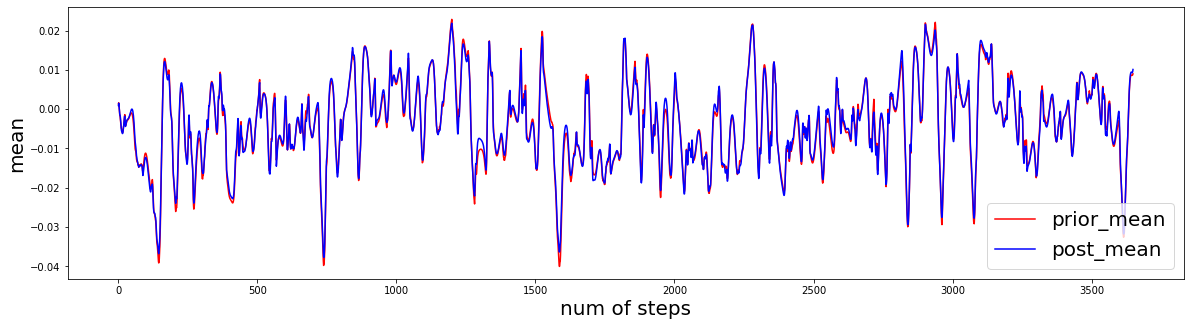

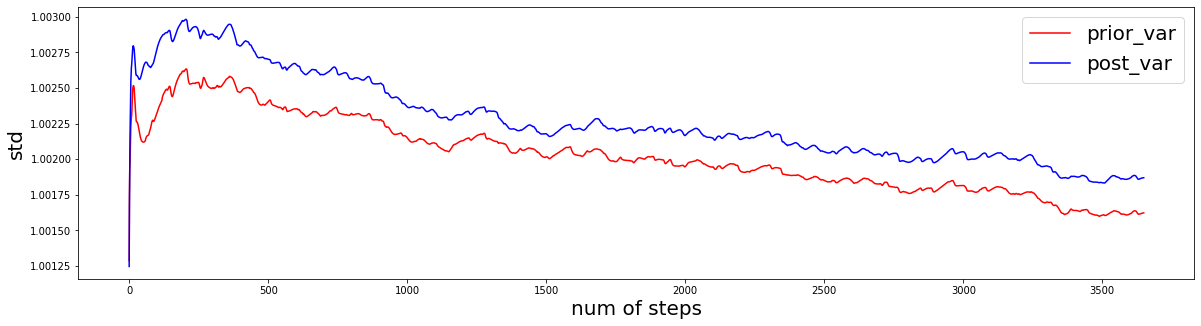

In [ ]:
# Plot prior and posterior mean distribution over steps
import matplotlib.pyplot as plt
plt.figure(figsize = (20,5))

n = np.random.randint(0, predict_y.shape[0])

pri = prior_z_mean[n][:,15]
post = posterior_z_mean[n][:,15]

plt.plot(np.arange(len(pri)), pri, c = 'red', label = 'prior_mean')
plt.plot(np.arange(len(post)), post, c = 'b', label = 'post_mean')
plt.xlabel('num of steps', fontsize = 20)
plt.ylabel('mean', fontsize = 20)
# plt.xscale('log') 
# plt.yscale('log')
# plt.xlim(500, 3000)
plt.legend(fontsize = 20)


# Plot prior and posterior std distribution over steps

plt.figure(figsize = (20,5))
pri = prior_z_log_sigma[n][:,15]
post = posterior_z_log_sigma[n][:,15]

plt.plot(np.arange(len(pri)), np.sqrt(np.exp(pri)), c = 'red', label = 'prior_var')
plt.plot(np.arange(len(post)), np.sqrt(np.exp(post)), c = 'b',  label = 'post_var')
plt.xlabel('num of steps', fontsize = 20)
plt.ylabel('std', fontsize = 20)
# plt.xlim(500, 3000)
# plt.xscale('log') 
plt.legend(fontsize = 20)

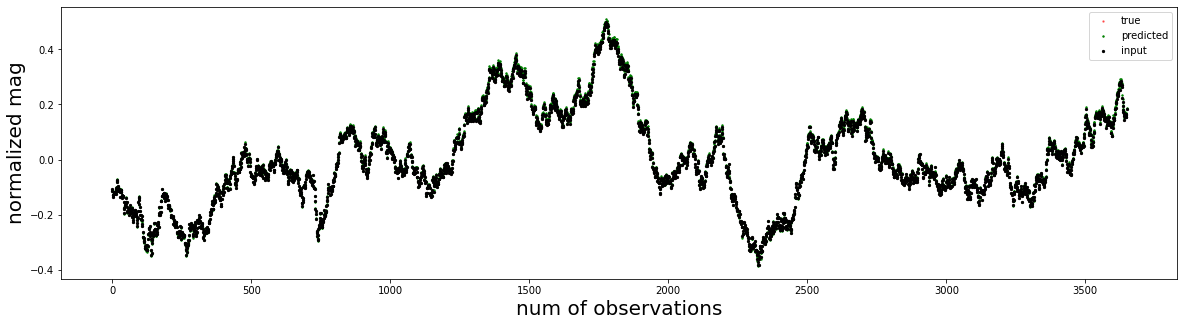

In [ ]:
import matplotlib.pyplot as plt

n = np.random.randint(0, predict_y.shape[0])

orig_lc = [0]
orig_diff_lc = predict_x[n]
# orig_diff_lc = predict_x[n,:,0]
start = 0
for i in orig_diff_lc:
  start += i
  orig_lc.append(start)


pred_diff_lc = prior_outputs[n].reshape(prior_outputs.shape[1])

pred_lc = [0]
start = 0
for i in pred_diff_lc:
  start += i
  pred_lc.append(start)



true_diff_lc = predict_y[n].reshape(predict_y.shape[1], )

true_lc = [0]
start = 0
for i in true_diff_lc:
  start += i
  true_lc.append(start)





plt.figure(figsize = (20,5))



plt.scatter(np.arange(len(true_diff_lc)), true_diff_lc, c = 'red', alpha = 0.5, label = 'true', s = 2)
plt.scatter(np.arange(len(pred_diff_lc)), pred_diff_lc, c = 'green', label = 'predicted', s = 2)
plt.scatter(np.arange(len(orig_diff_lc)), orig_diff_lc, c = 'black', label = 'input', s = 5)



# plt.plot(np.arange(len(true_diff_lc)), true_diff_lc, c = 'grey', label = 'true')
# plt.plot(np.arange(len(orig_diff_lc)), orig_diff_lc, c = 'green', label = 'input')
# plt.plot(np.arange(len(pred_diff_lc)), pred_diff_lc, c = 'red', label = 'predicted')


plt.legend(loc = 'upper right',fontsize = 10)
plt.xlabel('num of observations', fontsize = 20)
plt.ylabel('normalized mag', fontsize = 20)
plt.show()






In [ ]:
from eztao.ts import drw_fit, dho_fit
lc = true_diff_lc
best_fit_real = drw_fit(np.arange(len(lc)), lc, [0]*len(lc))
lc = pred_diff_lc
best_fit_pred = drw_fit(np.arange(len(lc)), lc, [0]*len(lc))
# lc = orig_diff_lc
# best_fit_orig = drw_fit(np.arange(len(lc)), lc, [0]*len(lc))
print('real DRW params: ', best_fit_real, ' \npredicted DRW params: ', best_fit_pred)

real DRW params:  [9.59889795e-02 1.22011292e+03]  
predicted DRW params:  [9.91212264e-02 1.03417772e+03]


In [ ]:
from eztao.ts import dho_fit
lc = true_diff_lc
best_fit_real = dho_fit(np.arange(len(lc)), lc, [0]*len(lc))
lc = pred_diff_lc
best_fit_pred = dho_fit(np.arange(len(lc)), lc, [0]*len(lc))
lc = orig_diff_lc
# best_fit_orig = dho_fit(np.arange(len(lc)), lc, [0]*len(lc))
print('real DHO params: ', best_fit_real, ' \npredicted DHO params: ', best_fit_pred)

real DHO params:  [0.07904721 0.0023634  0.00258573 0.02471436]  
predicted DHO params:  [5.54139144e+01 3.59363550e-02 2.20765820e-01 3.02340780e-02]


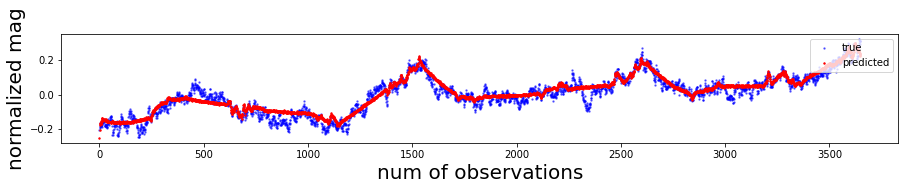

Text(0, 0.5, 'd')

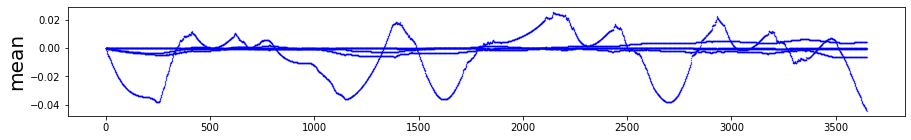

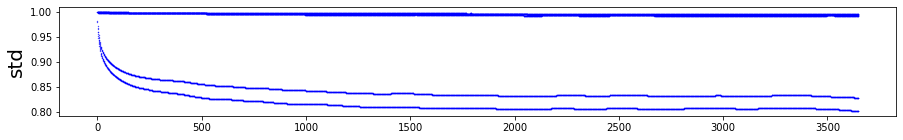

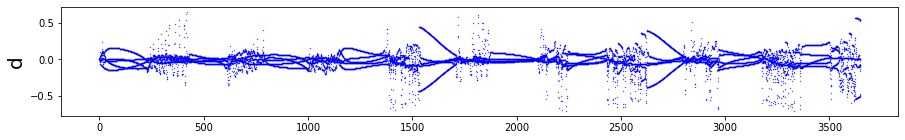

In [ ]:
# plotting in the paper
import matplotlib.pyplot as plt


n = np.random.randint(0, predict_y.shape[0])

pred_lc = prior_outputs[n].reshape(prior_outputs.shape[1])
true_lc = predict_y[n].reshape(predict_y.shape[1], )

plt.figure(figsize = (15,2))
plt.scatter(np.arange(len(true_lc)), true_lc, c = 'blue', alpha = 0.5, label = 'true', s = 2)
plt.scatter(np.arange(len(pred_lc)), pred_lc, c = 'red', label = 'predicted', s = 2)
plt.legend(loc = 'upper right',fontsize = 10)
plt.xlabel('num of observations', fontsize = 20)
plt.ylabel('normalized mag', fontsize = 20)
plt.show()


plt.figure(figsize = (15,2))
for m in np.arange(5):
  pri = prior_z_mean[n][:,m]
  plt.scatter(np.arange(len(pri)), pri, c = 'blue', s = 0.1)
plt.ylabel('mean', fontsize = 20)


# Plot prior and posterior std distribution over steps

plt.figure(figsize = (15,2))
for m in np.arange(5):
  pri = prior_z_log_sigma[n][:,m]
  plt.scatter(np.arange(len(pri)), np.sqrt(np.exp(pri)), c = 'blue', s = 0.1)
  # plt.xlim(500, 3000)
plt.ylabel('std', fontsize = 20)

plt.figure(figsize = (15,2))
for m in np.arange(5):
  d_value = d1_out[n,:,m]
  plt.scatter(np.arange(len(d_value)), d_value , c = 'blue', s = 0.1)
plt.ylabel('d', fontsize = 20)




In [ ]:
d1_out

array([-0.5349437 , -0.65996104, -0.24264422, ..., -0.12482419,
       -0.12464321, -0.12446056], dtype=float32)

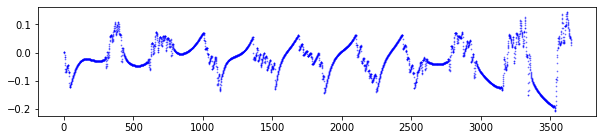

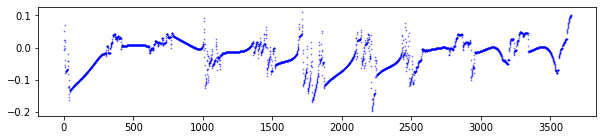

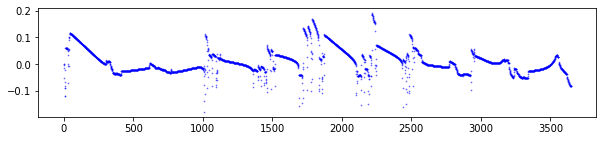

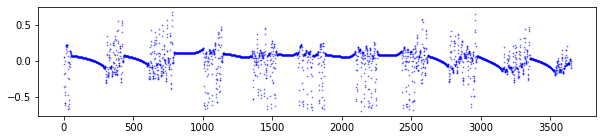

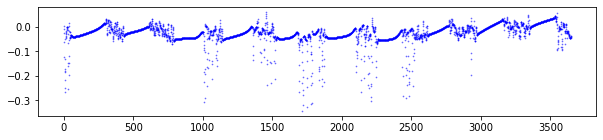

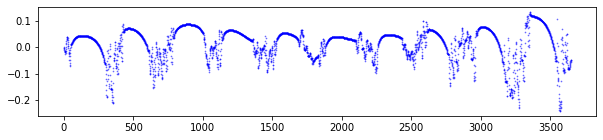

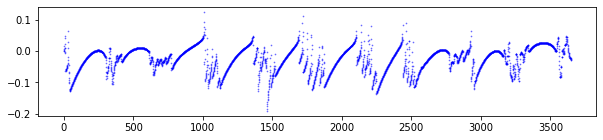

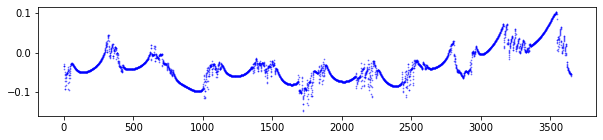

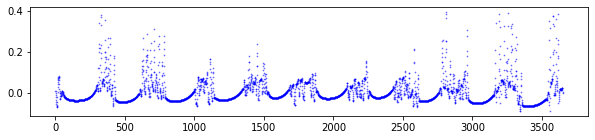

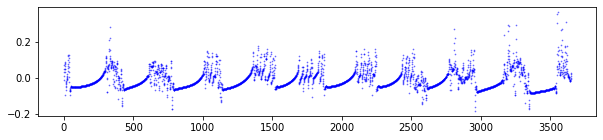

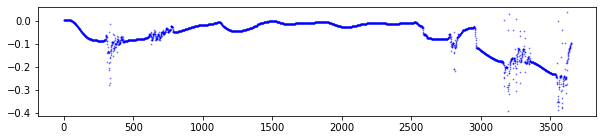

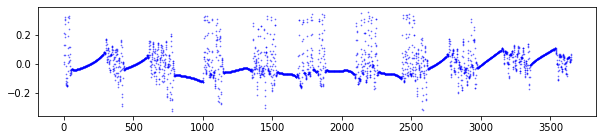

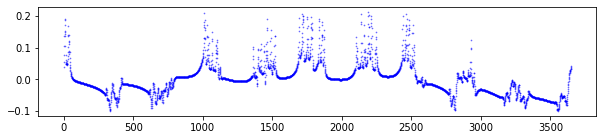

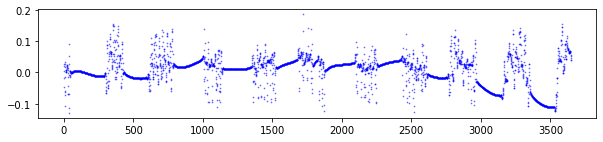

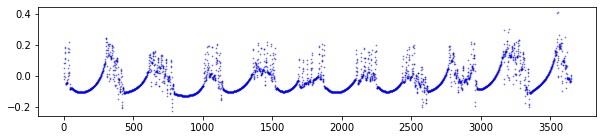

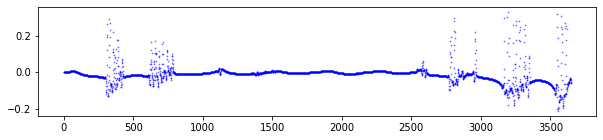

In [ ]:
# n = np.random.randint(0, predict_y.shape[0])

for m in np.arange(16):
  test = d1_out[n,:,m]
  # test = prior_z_mean[n][:,m]
  # test = prior_z_log_sigma[n][:,m]
  plt.figure(figsize = (10,2))
  plt.scatter(np.arange(len(test)), test, c = 'blue', alpha = 0.5, label = 'true', s = 0.5)
  plt.show()


In [ ]:
generative_model.save('drive/MyDrive/model_params/generative_model_1012_drw_full')
inference_model.save('drive/MyDrive/model_params/inference_model_1012_drw_full')



INFO:tensorflow:Assets written to: drive/MyDrive/model_params/generative_model_1012_drw_full/assets


INFO:tensorflow:Assets written to: drive/MyDrive/model_params/generative_model_1012_drw_full/assets


INFO:tensorflow:Assets written to: drive/MyDrive/model_params/inference_model_1012_drw_full/assets


INFO:tensorflow:Assets written to: drive/MyDrive/model_params/inference_model_1012_drw_full/assets


In [ ]:
!ls

drive  generative_model_824  inference_model_824  sample_data


In [ ]:
# X_inputs, [prior_outputs, prior_z_mean, prior_z_log_sigma]
prior_outputs, prior_z_mean, prior_z_log_sigma, d = generative_model2.predict(test_x)

# inference_model = Model([X_inputs, Y_inputs], [posterior_z_mean, posterior_z_log_sigma]
posterior_z_mean, posterior_z_log_sigma = inference_model2([d, test_y])

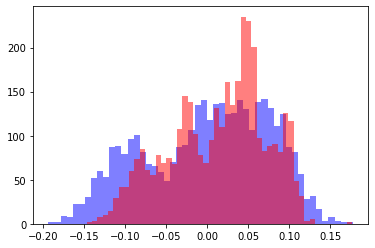

In [ ]:
# plot prediction and target output distributions
plt.hist(true_diff_lc, alpha = 0.5, bins = 50, color = 'b')
plt.hist(pred_diff_lc,  alpha = 0.5,bins = 50, color = 'r')
plt.show()

In [ ]:
print(np.mean(true_lc), np.mean(pred_lc))

116.94918279430505 141.35546194219486


In [ ]:
! /opt/bin/nvidia-smi

Wed Aug 18 07:00:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# plots on the paper

In [ ]:
generative_model = tf.keras.models.load_model('drive/MyDrive/model_params/generative_model_1004_drw_lsst_z')
inference_model = tf.keras.models.load_model('drive/MyDrive/model_params/inference_model_1004_drw_lsst_z')

generative_model.summary()
inference_model.summary()

Model: "generative_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_input (InputLayer)            [(None, 3650, 2)]    0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 3650, 64)     6912        X_input[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 3650, 64)     18816       bidirectional[0][0]              
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 3650, 64)     18816       bidirectional_1[0][0]            
___________________________________________________________________________________

In [ ]:
import json
def preprocess_add_zeros(miss_mjd, miss_y, miss_yerr, full_mjd):
  new_miss_mjd = full_mjd.copy()
  new_miss_y = np.zeros(len(new_miss_mjd))
  new_miss_yerr = np.zeros(len(new_miss_mjd))

  n = 0
  for i in new_miss_mjd:
    if i in miss_mjd:
      i_idx = np.where(miss_mjd == i)
      new_miss_y[n] = miss_y[i_idx[0][0]] 
      new_miss_yerr[n] = miss_yerr[i_idx[0][0]]
    n +=1
  # miss_sequence = [[t, y, yerr] for t, y, yerr in zip(new_miss_mjd, new_miss_y, new_miss_yerr)]
  return new_miss_mjd, new_miss_y, new_miss_yerr


def predict_lc(predict_x, predict_y, generative_model, inference_model):
  prior_outputs, prior_z_mean, prior_z_log_sigma, d1_out = generative_model.predict(predict_x)
  posterior_z_mean, posterior_z_log_sigma = inference_model.predict([d1_out, predict_y])
  return prior_outputs, prior_z_mean, prior_z_log_sigma, d1_out, posterior_z_mean, posterior_z_log_sigma

cadence_list = ['full','baseline', 'u_long', 'cadence_drive', 'rolling', 'filterdist']
band_list = ['u','g','r','i','z','y']

# select one object
obj = 1595
carma = 'drw'

# search for its real parameters
param_path = '/content/drive/Othercomputers/My MacBook Pro/SRNN_dataset/drw_3881.csv'
# param_path = '/content/drive/Othercomputers/My MacBook Pro/SRNN_dataset/overDHO_400.csv'
# param_path = '/content/drive/Othercomputers/My MacBook Pro/SRNN_dataset/underDHO_1075.csv'

param_set = pd.read_csv(param_path)
if carma == 'drw':
  obj_param = param_set[(param_set.SDR5ID == obj)]
else:
  obj_param = param_set[(param_set.id == obj)]
# print(obj_param)

filepath = '/content/drive/Othercomputers/My MacBook Pro/SRNN_dataset/lsst_obs_redshift/'+carma+'/'
f = open(filepath+str(obj)+'.json', 'r')
obj_info = json.load(f)


input_dataset = list()
target_dataset = list()
orig_dataset = list()

for band in band_list:
  if carma == 'drw':
    y_mean = obj_param['mu_'+band].values[0]
  else:
    y_mean = obj_param[obj_param.band == band]['mu'].values[0]
  for cad in cadence_list:
    obj_cs = obj_info[band][cad]
    if cad == 'full':
      full_mjd = np.around(obj_cs['mjd'], decimals=0)# set decimal to 0
      full_y = obj_cs['y']
      full_y -= y_mean
    else:
      miss_mjd = np.around(obj_cs['mjd'], decimals=0)
      miss_y = obj_cs['y']
      miss_yerr = obj_cs['yerr']
      orig_dataset.append(np.array([[t, y, yerr] for t, y, yerr in zip(miss_mjd, miss_y, miss_yerr)]))

      miss_y -= y_mean
      new_miss_mjd, new_miss_y, new_miss_yerr = preprocess_add_zeros(miss_mjd, miss_y, miss_yerr, full_mjd)
      input_dataset.append([[t, y, yerr] for t, y, yerr in zip(new_miss_mjd, new_miss_y, new_miss_yerr)])
      target_dataset.append([[t, y, yerr] for t, y, yerr in zip(full_mjd, full_y, np.zeros(len(full_mjd)))])

input_dataset, target_dataset = np.array(input_dataset), np.array(target_dataset)
print(input_dataset.shape, target_dataset.shape)


# predict_x = input_dataset[:,:,[1]]
# predict_y = target_dataset[:,:,[1]]

predict_x = input_dataset[:,:,[1,2]]
predict_y = target_dataset[:,:,[1]]

prior_outputs, prior_z_mean, prior_z_log_sigma, d1_out = generative_model.predict(predict_x)
posterior_z_mean, posterior_z_log_sigma = inference_model.predict([d1_out, predict_y])

(30, 3650, 3) (30, 3650, 3)


In [ ]:
obj_param

Unnamed: 0  SDR5ID        ra  ...     mu_g      SF_g     tau_g
40          40   151.0  1.141382  ...  19.8451  0.384079  3858.336

[1 rows x 23 columns]

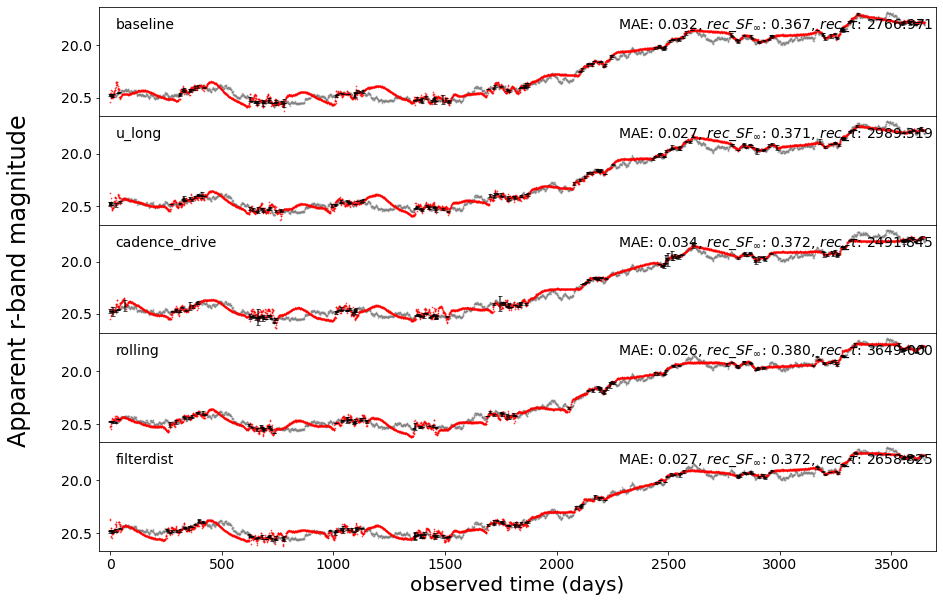

In [ ]:
import matplotlib.pyplot as plt
from eztao.ts import drw_fit, dho_fit

cadence_dist = {'baseline':0, 'u_long':1, 'cadence_drive':2, 'rolling':3, 'filterdist':4}
band_dist = {'u':0,'g':1,'r':2,'i':3,'z':4,'y':5}

# DHO overdamping
def get_DHO_overdamping_metric(ar_overdamping):
    import numpy as np
    alpha_0 = ar_overdamping[0]
    alpha_1 = ar_overdamping[1]
    r1 = (-alpha_0 - np.sqrt(alpha_0**2 - 4*alpha_1))/2
    r2 = (-alpha_0 + np.sqrt(alpha_0**2 - 4*alpha_1))/2

    tau_rise = 1./(r2-r1)*np.log(abs(r1/r2))
    tau_decay = abs(1/max(r1,r2))
    return tau_rise,tau_decay

# DHO underdamped 
def get_DHO_underdamped_metric(ar_underdamped):
    import cmath
    alpha_1 = ar_underdamped[0]
    alpha_2 = ar_underdamped[1]
    T_QPO = 2*np.pi/np.sqrt(alpha_2)
    T_dQPO = 4*np.pi/np.sqrt(4*alpha_2 - alpha_1**2)
    tau_decay = 2/alpha_1
    return T_QPO,T_dQPO,tau_decay

def mae(pred_lc, true_lc):
  return np.mean(abs(pred_lc - true_lc))

def get_CARMA(carma, mjd, y, yerr):
  if carma == 'drw':
    best_fit_pred = drw_fit(mjd, y, yerr)
    sf = best_fit_pred[0]
    tau = best_fit_pred[1]
    return [sf, tau]
  else:
    best_fit_pred = dho_fit(mjd, y, yerr)
    alpha1, alpha2, beta0, beta1 = best_fit_pred
    sf = np.sqrt(2*(beta0**2 + alpha2*beta1**2)/(2*alpha1*alpha2))
    if carma == 'under':
      T_QPO,T_dQPO,tau_decay = get_DHO_underdamped_metric([alpha1, alpha2])
      return [T_QPO,T_dQPO,tau_decay, sf]
    else: 
      tau_rise,tau_decay = get_DHO_overdamping_metric([alpha1, alpha2])
      return [tau_rise,tau_decay, sf]


def plot_prediction(carma, axs, obj_param, cadence, band, predict_x, predict_y, prior_outputs, orig_dataset):
  n = band_dist[band]*5 + cadence_dist[cadence]
  if carma == 'drw':
    mean_y = obj_param['mu_'+band].values[0]
  else:
    mean_y = obj_param[obj_param.band == band]['mu'].values[0]
  pred_lc = prior_outputs[n].reshape(prior_outputs.shape[1])
  true_lc = predict_y[n].reshape(predict_y.shape[1], )
  
  loss = mae(pred_lc, true_lc)
  
  result_pred = get_CARMA(carma, np.arange(len(pred_lc)), pred_lc, np.zeros(len(pred_lc)))
  result_ori = get_CARMA(carma, orig_dataset[n][:,0], orig_dataset[n][:,1], orig_dataset[n][:,2])
  result_true = get_CARMA(carma, np.arange(len(true_lc)), true_lc, np.zeros(len(true_lc)))

  redshift = obj_param['redshift'].values[0]
  
  axs.scatter(np.arange(len(true_lc)), true_lc+mean_y, c = 'grey', alpha = 0.5, label = 'true', s = 0.5)
  axs.scatter(np.arange(len(pred_lc)), pred_lc+mean_y, c = 'red', alpha = 0.7, label = 'predicted', s = 0.5)
  axs.errorbar(orig_dataset[n][:,0], orig_dataset[n][:,1], orig_dataset[n][:,2], fmt='.', markersize='1', c = 'black',alpha = 0.7, capsize=2, elinewidth=1.5)
  axs.text(0.02, 0.8, transform=axs.transAxes,  s = cadence, fontsize = 14)
  if carma == 'drw':
    axs.text(0.62, 0.8, transform=axs.transAxes,  s = r'MAE: %.3f, $rec\_SF_{\infty}$: %.3f, $rec\_\tau$: %.3f'%(loss, result_pred[0], result_pred[1]), fontsize = 14)
  elif carma == 'under':
    axs.text(0.42, 0.8, transform=axs.transAxes,  s = r'MAE: %.3f, $rec\_SF_{\infty}$: %.3f, $rec\_T_{QPO}$: %.3f, $rec\_\tau_{decay}$: %.3f'%(loss, result_pred[3], result_pred[0], result_pred[2]), fontsize = 14)
  else:
    axs.text(0.45, 0.8, transform=axs.transAxes,  s = r'MAE: %.3f, $rec\_SF_{\infty}$: %.3f, $rec\_\tau_{rise}$: %.3f, $rec\_\tau_{decay}$: %.3f'%(loss, result_pred[2], result_pred[0], result_pred[1]), fontsize = 14)

  return result_pred, result_ori, result_true

  

band = 'r'

fig, axs = plt.subplots(5, 1, figsize=(15,10),sharex='col',gridspec_kw={'hspace': 0, 'wspace': 0})

n = 0
for cadence in cadence_dist.keys():
  result_pred, result_ori, result_true = plot_prediction(carma, axs[n], obj_param, cadence, band, predict_x, predict_y, prior_outputs, orig_dataset)
  # print(result_pred, result_ori, result_true)
  axs[n].set_xlim([-50,3700])
  axs[n].invert_yaxis()
  # axs[n].set_ylim([19.75,20.75])
  axs[n].tick_params(axis="x", labelsize=14)
  axs[n].tick_params(axis="y", labelsize=14)
  # axs[n].set_yticks([20.00, 20.25, 20.50])
  # axs[n].set_ylabel(band, fontsize = 20)
  axs[n].set_xlabel('observed time (days)', fontsize = 20)
  n += 1


fig.text(0.04, 0.5, 'Apparent '+band+'-band magnitude', va='center', rotation='vertical', fontsize = 24)
plt.show()



In [ ]:
if carma == 'drw':
  sf = obj_param['SF_'+band].values[0]
  tau = obj_param['tau_'+band].values[0]
  redshift = obj_param['redshift'].values[0]
  print('SF: %.3f, tau: %.3f, z: %.3f'%(sf, tau, redshift))
else:
  sf = obj_param[obj_param.band == band]['SF'].values[0]
  alpha1 = obj_param[obj_param.band == band]['alpha1'].values[0]
  alpha2 = obj_param[obj_param.band == band]['alpha2'].values[0]
  redshift = obj_param['redshift'].values[0]
  if carma == 'over':
    tau_rise,tau_decay = get_DHO_overdamping_metric([alpha1, alpha2])
    print('SF: %.3f, tau_rise: %.3f, tau_decay: %.3f, z: %.3f'%(sf, tau_rise, tau_decay, redshift))
  elif carma == 'under':
    T_QPO,T_dQPO,tau_decay = get_DHO_underdamped_metric([alpha1, alpha2])
    print('SF: %.3f, T_QPO: %.3f, tau_decay: %.3f, z: %.3f'%(sf, T_QPO, tau_decay, redshift))


SF: 0.218, tau: 691.656, z: 1.677


In [ ]:
result_true, result_ori, result_pred

([31.141288596482465, 1143.8187557336485, 0.1649901149167307],
 [30.29027596158512, 1143.4420342415738, 0.16015305436365312],
 [0.10404699082930495, 1502.0530002533947, 0.14740789407572125])

# plot tau_in, tau_out (after SRNN)

In [ ]:
!pip install eztao

In [ ]:
# setup
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# add RNN-related API
from tensorflow.keras.layers import (Input, Dense, TimeDistributed, LSTM, GRU, Dropout, concatenate, Lambda, Masking, Embedding,
                          Flatten, RepeatVector, Bidirectional)
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from keras import backend as K
# from keras import objectives
from keras import losses
# from keras.objectives import binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the TensorBoard notebook extension
%load_ext tensorboard

import datetime
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [ ]:
generative_model = tf.keras.models.load_model('drive/MyDrive/model_params/generative_model_1004_drw_lsst_z')
inference_model = tf.keras.models.load_model('drive/MyDrive/model_params/inference_model_1004_drw_lsst_z')

generative_model.summary()
inference_model.summary()

Model: "generative_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_input (InputLayer)            [(None, 3650, 2)]    0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 3650, 64)     6912        X_input[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 3650, 64)     18816       bidirectional[0][0]              
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 3650, 64)     18816       bidirectional_1[0][0]            
___________________________________________________________________________________

### DRW case

In [ ]:
# pass every object to the SRNN model, and gain the params, store them in a new .csv file
import pandas as pd
import json
import numpy as np

def normalization(data):
  return (data - np.mean(data))/np.std(data)

def preprocess_add_zeros(miss_mjd, miss_y, miss_yerr, full_mjd):
  new_miss_mjd = full_mjd.copy()
  new_miss_y = np.zeros(len(new_miss_mjd))
  new_miss_yerr = np.zeros(len(new_miss_mjd))

  n = 0
  for i in new_miss_mjd:
    if i in miss_mjd:
      i_idx = np.where(miss_mjd == i)
      new_miss_y[n] = miss_y[i_idx[0][0]] 
      new_miss_yerr[n] = miss_yerr[i_idx[0][0]]
    n +=1
  return new_miss_mjd, new_miss_y, new_miss_yerr


cadence_list = ['full','baseline', 'u_long', 'cadence_drive', 'rolling', 'filterdist']
band_list = ['u','g','r','i','z','y']


carma = 'drw'
param_path = '/content/drive/Othercomputers/My MacBook Pro/SRNN_dataset/drw_3881.csv'
param_set = pd.read_csv(param_path)
id_list = param_set['SDR5ID'][320:400].tolist()

input_dataset = list()
target_dataset = list()

for id in id_list:
  filepath = '/content/drive/Othercomputers/My MacBook Pro/SRNN_dataset/lsst_obs_redshift/'+carma+'/'
  f = open(filepath+str(int(id))+'.json', 'r')
  obj_info = json.load(f)
  for band in band_list:
    obj_band = obj_info[band]
    for cad in cadence_list:
      obj_cs = obj_band[cad]
      if cad == 'full':
        full_mjd = np.around(obj_cs['mjd'], decimals=0) # set decimal to 0
        full_y = obj_cs['y']
        real_mean = np.mean(full_y)
        full_y -= real_mean
      else:
        miss_mjd = np.around(obj_cs['mjd'], decimals=0)
        miss_y = obj_cs['y']
        miss_y -= real_mean
        miss_yerr = obj_cs['yerr']  
        new_miss_mjd, new_miss_y, new_miss_yerr = preprocess_add_zeros(miss_mjd, miss_y, miss_yerr, full_mjd)
        miss_sequence = [[t, y, yerr] for t, y, yerr in zip(new_miss_mjd, new_miss_y, new_miss_yerr)]
        # full_sequence = [[t, y, yerr] for t, y, yerr in zip(full_mjd, full_y, np.zeros(len(full_mjd)))]
        
        input_dataset.append(miss_sequence)
        # target_dataset.append(full_sequence)


input_dataset = np.array(input_dataset)

print(input_dataset.shape)



(2400, 3650, 3)


In [ ]:
del prior_z_mean, prior_z_log_sigma, d1_out

In [ ]:
prior_outputs, prior_z_mean, prior_z_log_sigma, d1_out = generative_model.predict(input_dataset[:,:,[1,2]])

In [ ]:
from eztao.ts import drw_fit, dho_fit
import math

def get_CARMA(carma, mjd, y, yerr):
  if carma == 'drw':
    best_fit_pred = drw_fit(mjd, y, yerr)
    sf = best_fit_pred[0]
    tau = best_fit_pred[1]
    return [sf, tau]
  else:
    best_fit_pred = dho_fit(mjd, y, yerr)
    alpha1, alpha2, beta0, beta1 = best_fit_pred
    sf = np.sqrt(2*(beta0**2 + alpha2*beta1**2)/(2*alpha1*alpha2))
    if carma == 'under':
      T_QPO,T_dQPO,tau_decay = get_DHO_underdamped_metric([alpha1, alpha2])
      return [T_QPO,T_dQPO,tau_decay, sf]
    else: 
      tau_rise,tau_decay = get_DHO_overdamping_metric([alpha1, alpha2])
      return [tau_rise,tau_decay, sf]

cadence_list = ['baseline', 'u_long', 'cadence_drive', 'rolling', 'filterdist']
band_list = ['u','g','r','i','z','y']

# srnn_df = pd.DataFrame(columns = ['id', 'tau_in', 'tau_srnn','sf_in', 'sf_srnn', 'cadence', 'band'])


all_param = list()

obj_num = int(prior_outputs.shape[0]/30)
n = 0
while n < prior_outputs.shape[0]:
  m = math.ceil(n/30)
  print(m)
  dict_id = {'id': id_list[m]}
  ori_set = param_set[param_set.SDR5ID==id_list[m]]
  for band in band_list:
    dict_band = {'band': band, 'tau_in': ori_set['tau_'+band].values[0], 'sf_in':ori_set['SF_'+band].values[0]}
    for cad in cadence_list:
      dict_cad = {'cadence': cad}
      pred_lc = prior_outputs[n].reshape(prior_outputs.shape[1])
      pred_lc -= np.mean(pred_lc)
      fit = get_CARMA('drw', np.arange(len(pred_lc)), pred_lc, np.zeros(len(pred_lc)))
      srnn_param = {'sf_srnn': fit[0], 'tau_srnn':fit[1]}
      srnn_param.update(dict_band)
      srnn_param.update(dict_id)
      srnn_param.update(dict_cad)
      # print(srnn_param)
      all_param.append(srnn_param)
      n += 1

srnn_df = pd.DataFrame(all_param) 


  
 


In [ ]:
srnn_df.to_csv('drive/MyDrive/srnn_drw_4_redshift.csv')

In [ ]:
del srnn_df, prior_outputs, prior_z_mean, prior_z_log_sigma, d1_out

Text(0, 0.5, 'tau')

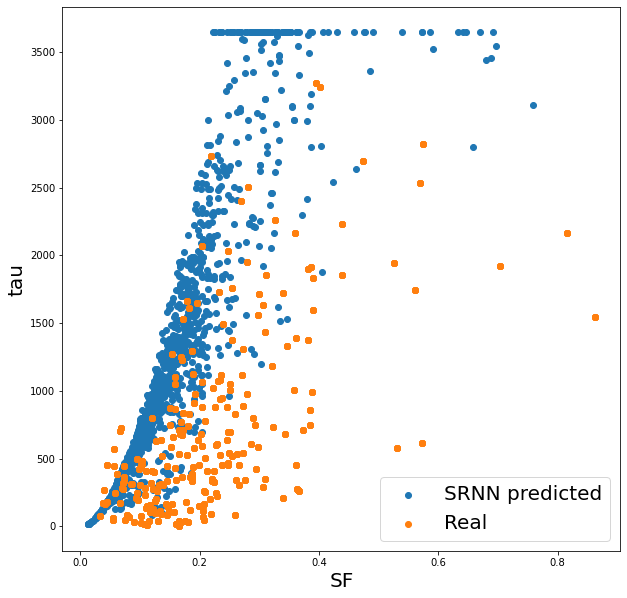

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(srnn_df['sf_srnn'], srnn_df['tau_srnn'], label = 'SRNN predicted')
plt.scatter(srnn_df['sf_in'], srnn_df['tau_in'], label = 'Real')
# plt.yscale('log')
# plt.xscale('log')
plt.legend(fontsize = 20)
plt.xlabel('SF', fontsize = 20)
plt.ylabel('tau', fontsize = 20)

In [ ]:
# caculate the cadenced-light curve directly
import pandas as pd
import json
import numpy as np
from eztao.ts import drw_fit, dho_fit
import math

def get_CARMA(carma, mjd, y, yerr):
  if carma == 'drw':
    best_fit_pred = drw_fit(mjd, y, yerr)
    sf = best_fit_pred[0]
    tau = best_fit_pred[1]
    return [sf, tau]
  else:
    best_fit_pred = dho_fit(mjd, y, yerr)
    alpha1, alpha2, beta0, beta1 = best_fit_pred
    sf = np.sqrt(2*(beta0**2 + alpha2*beta1**2)/(2*alpha1*alpha2))
    if carma == 'under':
      T_QPO,T_dQPO,tau_decay = get_DHO_underdamped_metric([alpha1, alpha2])
      return [T_QPO,T_dQPO,tau_decay, sf]
    else: 
      tau_rise,tau_decay = get_DHO_overdamping_metric([alpha1, alpha2])
      return [tau_rise,tau_decay, sf]

cadence_list = ['baseline', 'u_long', 'cadence_drive', 'rolling', 'filterdist']
band_list = ['u','g','r','i','z','y']


carma = 'drw'
param_path = '/content/drive/Othercomputers/My MacBook Pro/SRNN_dataset/drw_3881.csv'
param_set = pd.read_csv(param_path)
id_list = param_set['SDR5ID'][:1000].tolist()


all_param = list()

for id in id_list:
  print(id)
  dict_id = {'id': id}
  ori_set = param_set[param_set.SDR5ID==id]
  filepath = '/content/drive/Othercomputers/My MacBook Pro/SRNN_dataset/lsst_obs_identical/'+carma+'/'
  f = open(filepath+str(int(id))+'.json', 'r')
  obj_info = json.load(f)
  for band in band_list:
    dict_band = {'band': band, 'tau_in': ori_set['tau_'+band].values[0], 'sf_in':ori_set['SF_'+band].values[0]}
    obj_band = obj_info[band]
    for cad in cadence_list:
      dict_cad = {'cadence': cad}
      
      obj_cs = obj_band[cad]
      miss_mjd = np.around(obj_cs['mjd'], decimals=0)
      miss_y = obj_cs['y']
      miss_y -= np.mean(miss_y)
      miss_yerr = obj_cs['yerr']
      fit = get_CARMA('drw', miss_mjd, miss_y, miss_yerr)
      lsst_param = {'sf_lsst': fit[0], 'tau_lsst':fit[1]}
      lsst_param.update(dict_band)
      lsst_param.update(dict_id)
      lsst_param.update(dict_cad)
      all_param.append(lsst_param)

lsst_df = pd.DataFrame(all_param) 



In [ ]:
lsst_df.to_csv('drive/MyDrive/lsst_drw_all.csv')

(array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

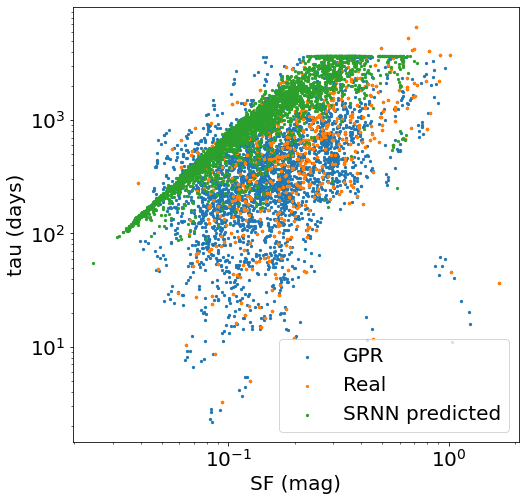

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(lsst_df['sf_lsst'], lsst_df['tau_lsst'], label = 'GPR', s = 5)
plt.scatter(lsst_df['sf_in'], lsst_df['tau_in'], label = 'Real', s = 5)
plt.scatter(srnn_df['sf_srnn'], srnn_df['tau_srnn'], label = 'SRNN predicted', s = 5)
plt.yscale('log') 
plt.xscale('log') 
plt.legend(fontsize = 20)
plt.xlabel('SF (mag)', fontsize = 20)
plt.ylabel('tau (days)', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()


In [ ]:
srnn_df = pd.read_csv('drive/MyDrive/srnn_drw_1.csv')

for i in np.arange(2,17):
  df2 = pd.read_csv('drive/MyDrive/srnn_drw_'+str(i)+'.csv')
  srnn_df = pd.concat([srnn_df, df2])
  del df2


In [ ]:
srnn_df.to_csv('drive/MyDrive/srnn_drw_all.csv')

In [ ]:
srnn_df = pd.read_csv('drive/MyDrive/srnn_drw_all.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


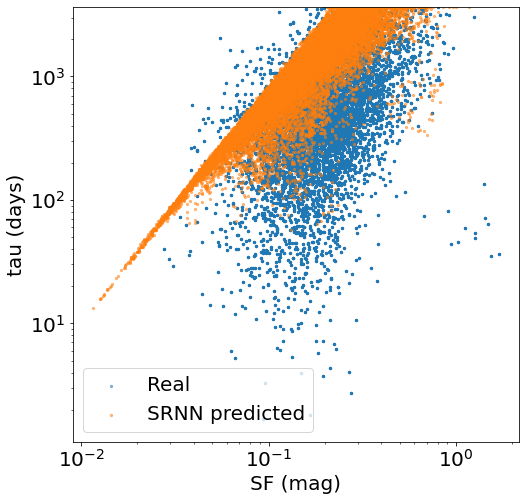

In [ ]:

sel_df = srnn_df
plt.figure(figsize=(8,8))
# sel_df = srnn_df[(srnn_df.cadence=='baseline')&(srnn_df.band == 'u')]
plt.scatter(sel_df['sf_in'], sel_df['tau_in'], label = 'Real', s = 5, alpha = 0.5)
plt.scatter(sel_df['sf_srnn'], sel_df['tau_srnn'], label = 'SRNN predicted', s = 5, alpha = 0.5)
plt.yscale('log') 
plt.xscale('log') 
plt.legend(fontsize = 20)
plt.xlabel('SF (mag)', fontsize = 20)
plt.ylabel('tau (days)', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylim(0, 3650)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  if sys.path[0] == '':


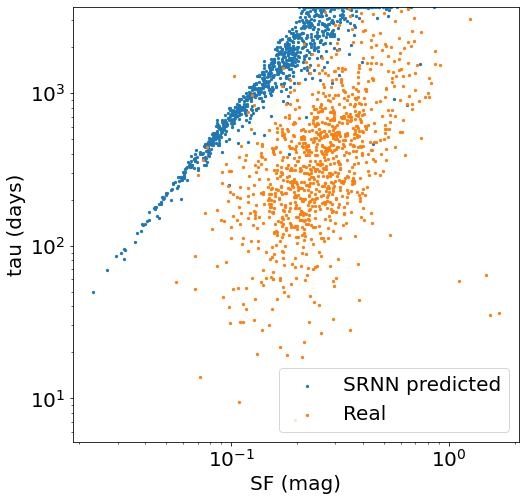

In [ ]:
sel_df = srnn_df[(srnn_df.cadence=='rolling')&(srnn_df.band == 'u')]
plt.figure(figsize=(8,8))
plt.scatter(sel_df['sf_srnn'], sel_df['tau_srnn'], label = 'SRNN predicted', s = 5)
plt.scatter(sel_df['sf_in'], sel_df['tau_in'], label = 'Real', s = 5)
plt.yscale('log') 
plt.xscale('log') 
plt.legend(fontsize = 20)
plt.xlabel('SF (mag)', fontsize = 20)
plt.ylabel('tau (days)', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylim(0, 3650)
plt.show()

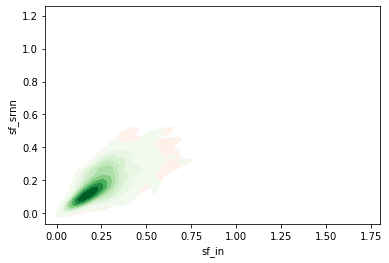

In [ ]:
import seaborn as sns




# , bw_adjust=.5 
sel_df = srnn_df[srnn_df.band == 'u']
sns.kdeplot(x=sel_df['sf_in'], y=sel_df['sf_srnn'], cmap="Reds", shade=True)
sel_df = srnn_df[srnn_df.band == 'g']
sns.kdeplot(x=sel_df['sf_in'], y=sel_df['sf_srnn'], cmap="Greens", shade=True)

# plt.yscale('log') 
# plt.xscale('log') 
plt.show()

# # delta = 0.025
# # x = np.arange(-3.0, 3.0, delta)
# # y = np.arange(-2.0, 2.0, delta)
# x = sel_df['sf_in']
# y = sel_df['sf_srnn']
# X, Y = np.meshgrid(x, y)
# # Z1 = np.exp(-X**2 - Y**2)
# # Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
# # Z = X
# fig, ax = plt.subplots()
# CS = ax.contour(x,y, Z)

# # ax.legend()
# # ax.clabel(CS, inline=True, fontsize=10)
# ax.set_title('Simplest default with labels')

In [ ]:
Z1.shape

(160, 240)

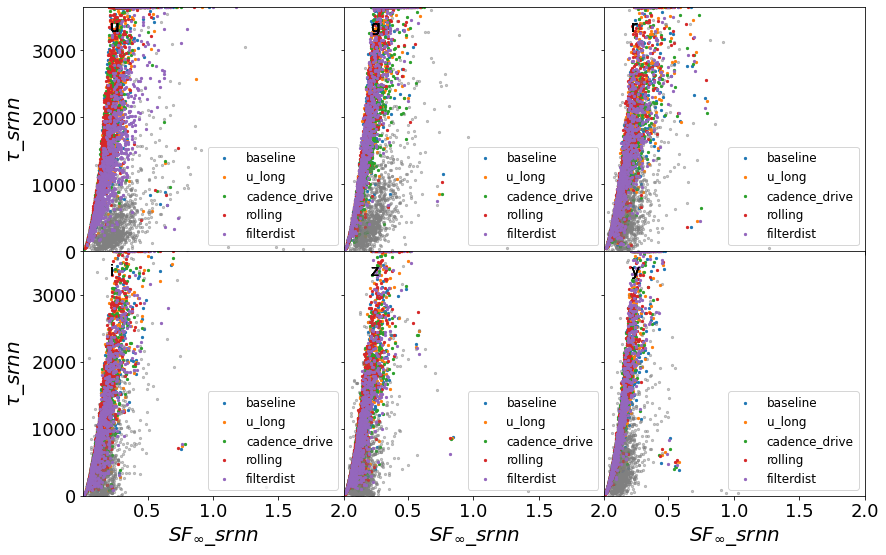

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(14,9),sharex='col',sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0})
band_list = ['u','g','r','i','z','y']
cadence_list = ['baseline', 'u_long', 'cadence_drive', 'rolling', 'filterdist']
n = 0
for row in np.arange(2):
  for col in np.arange(3):
    ax = axs[row, col]
    for cad in cadence_list:
      sel_df = srnn_df[(srnn_df.cadence==cad)&(srnn_df.band==band_list[n])]
      ax.scatter(sel_df['sf_in'], sel_df['tau_in'], color = 'grey', alpha = 0.1, s = 5)
      ax.scatter(sel_df['sf_srnn'], sel_df['tau_srnn'], label = cad, s = 5)
      ax.text(0.1, 0.9, transform=ax.transAxes, s = band_list[n], fontsize = 15)
      # ax.set_yscale('log') 
      # ax.set_xscale('log') 
      ax.set_xlim([1e-2, 2])
      ax.set_ylim(0, 3650)
      ax.tick_params(axis="x", labelsize=18)
      ax.tick_params(axis="y", labelsize=18)
            
    ax.legend(loc = 'lower right', fontsize = 12)
    if row == 1:
      ax.set_xlabel(r'$SF_{\infty}\_srnn$', fontsize = 20)
    if col == 0:
      ax.set_ylabel(r'$\tau\_srnn$', fontsize = 20)
    n += 1
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


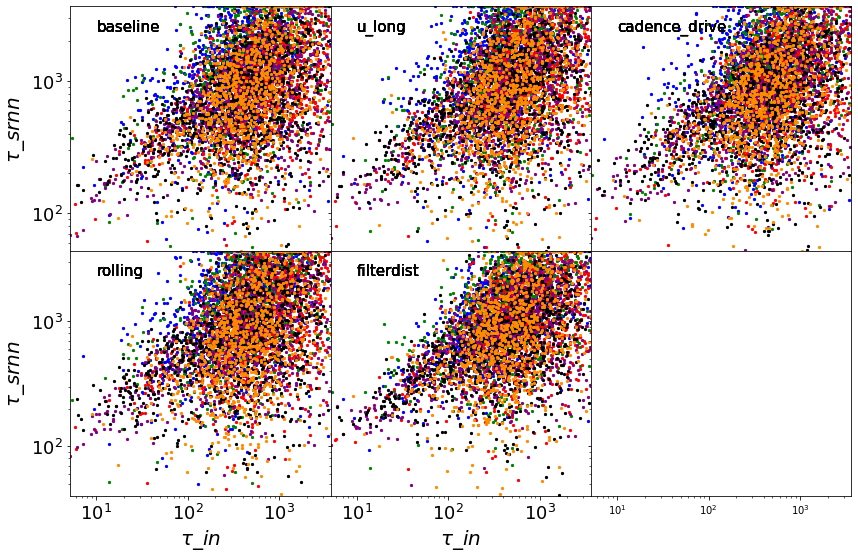

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(14,9),sharex='col',sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0})
band_list = ['u','g','r','i','z','y']

band_color = {'u':'blue', 'g':'green','r':'red', 'i':'purple', 'z':'black','y':'darkorange'}
cadence_list = ['baseline', 'u_long', 'cadence_drive', 'rolling', 'filterdist']

n = 0
for row in np.arange(2):
  for col in np.arange(3):
    ax = axs[row, col]
    if n<5:
      for band in band_list:
        sel_df = srnn_df[(srnn_df.cadence==cadence_list[n])&(srnn_df.band==band)]
        ax.scatter(sel_df['tau_in'], sel_df['tau_srnn'], label = band, s = 5, color = band_color[band])
        ax.text(0.1, 0.9, transform=ax.transAxes, s = cadence_list[n], fontsize = 15)
        ax.set_yscale('log') 
        ax.set_xscale('log') 
        ax.set_xlim(0, 3650)
        ax.set_ylim(0, 3650)
        ax.tick_params(axis="x", labelsize=18)
        ax.tick_params(axis="y", labelsize=18)
              
      # ax.legend(loc = 'lower right', fontsize = 12)
      if row == 1:
        ax.set_xlabel(r'$\tau\_in$', fontsize = 20)
      if col == 0:
        ax.set_ylabel(r'$\tau\_srnn$', fontsize = 20)
      if row == 1 and col == 2:
        ax.set_xticks([])
        ax.set_yticks([])
    n += 1
plt.show()


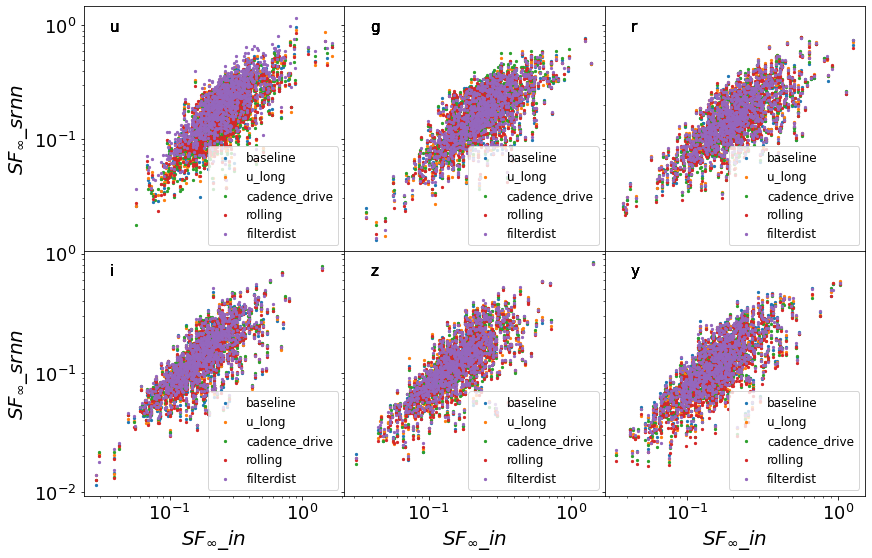

In [ ]:


fig, axs = plt.subplots(2, 3, figsize=(14,9),sharex='col',sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0})
band_list = ['u','g','r','i','z','y']
n = 0
for row in np.arange(2):
  for col in np.arange(3):
    ax = axs[row, col]
    for cad in cadence_list:
      sel_df = srnn_df[(srnn_df.cadence==cad)&(srnn_df.band==band_list[n])]
      ax.scatter(sel_df['sf_in'], sel_df['sf_srnn'], label = cad, s = 5)
      ax.text(0.1, 0.9, transform=ax.transAxes, s = band_list[n], fontsize = 15)
      ax.set_yscale('log') 
      ax.set_xscale('log') 
      # ax.set_xticks([1e-2, 1e-1, 1e0])
      # ax.set_xlim([1e-2, 2])
      # ax.set_ylim(0, 3650)
      ax.tick_params(axis="x", labelsize=18)
      ax.tick_params(axis="y", labelsize=18)
            
    ax.legend(loc = 'lower right', fontsize = 12)
    if row == 1:
      ax.set_xlabel(r'$SF_{\infty}\_in$', fontsize = 20)
    if col == 0:
      ax.set_ylabel(r'$SF_{\infty}\_srnn$', fontsize = 20)
    n += 1
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  del sys.path[0]


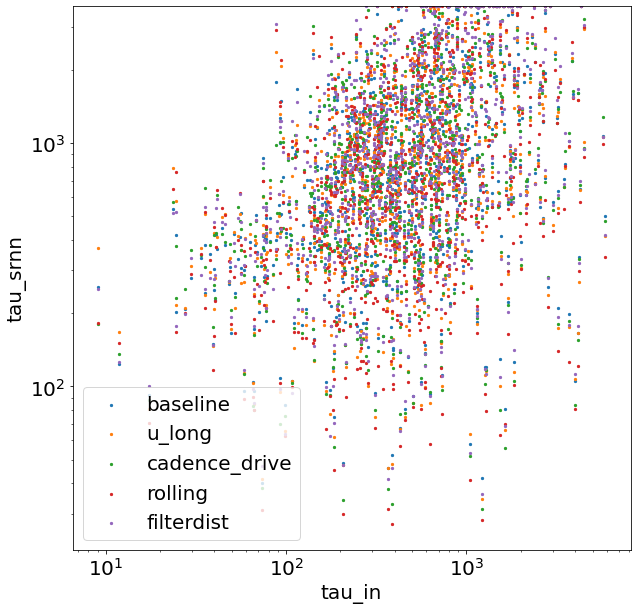

In [ ]:
cadence_list = ['baseline', 'u_long', 'cadence_drive', 'rolling', 'filterdist']
plt.figure(figsize=(10,10))
for cad in cadence_list:
  sel_df = srnn_df[(srnn_df.cadence==cad)&(srnn_df.band == 'y')]
  plt.scatter(sel_df['tau_in'], sel_df['tau_srnn'], s = 5, label = cad)
plt.yscale('log') 
plt.xscale('log') 
plt.legend(fontsize = 20)
plt.xlabel('tau_in', fontsize = 20)
plt.ylabel('tau_srnn', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylim(0, 3650)
plt.show()

In [ ]:
lsst_df = pd.read_csv('drive/MyDrive/lsst_drw_all.csv')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


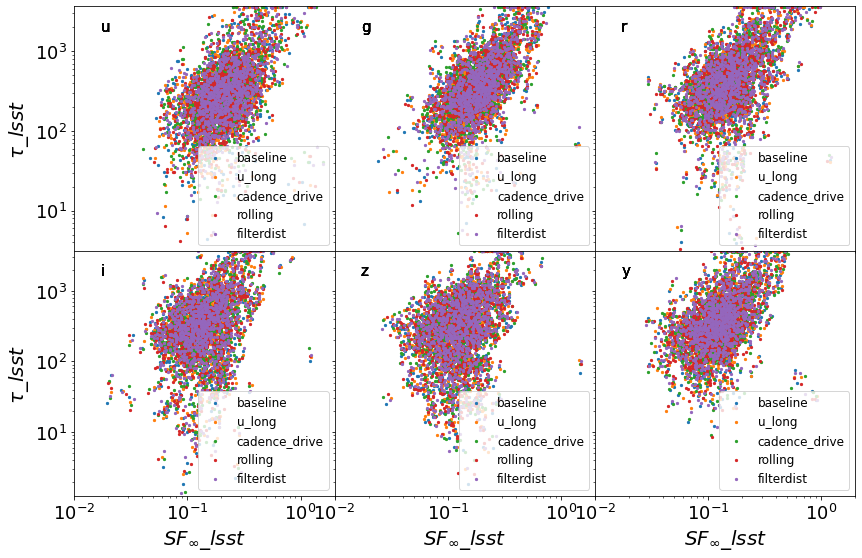

In [ ]:


fig, axs = plt.subplots(2, 3, figsize=(14,9),sharex='col',sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0})
band_list = ['u','g','r','i','z','y']
n = 0
for row in np.arange(2):
  for col in np.arange(3):
    ax = axs[row, col]
    for cad in cadence_list:
      sel_df = lsst_df[(lsst_df.cadence==cad)&(lsst_df.band==band_list[n])]
      ax.scatter(sel_df['sf_lsst'], sel_df['tau_lsst'], label = cad, s = 5)
      ax.text(0.1, 0.9, transform=ax.transAxes, s = band_list[n], fontsize = 15)
      ax.set_yscale('log') 
      ax.set_xscale('log') 
      # ax.set_xticks([1e-2, 1e-1, 1e0])
      ax.set_xlim([1e-2, 2])
      ax.set_ylim(0, 3650)
      ax.tick_params(axis="x", labelsize=18)
      ax.tick_params(axis="y", labelsize=18)
            
    ax.legend(loc = 'lower right', fontsize = 12)
    if row == 1:
      ax.set_xlabel(r'$SF_{\infty}\_lsst$', fontsize = 20)
    if col == 0:
      ax.set_ylabel(r'$\tau\_lsst$', fontsize = 20)
    n += 1
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  app.launch_new_instance()


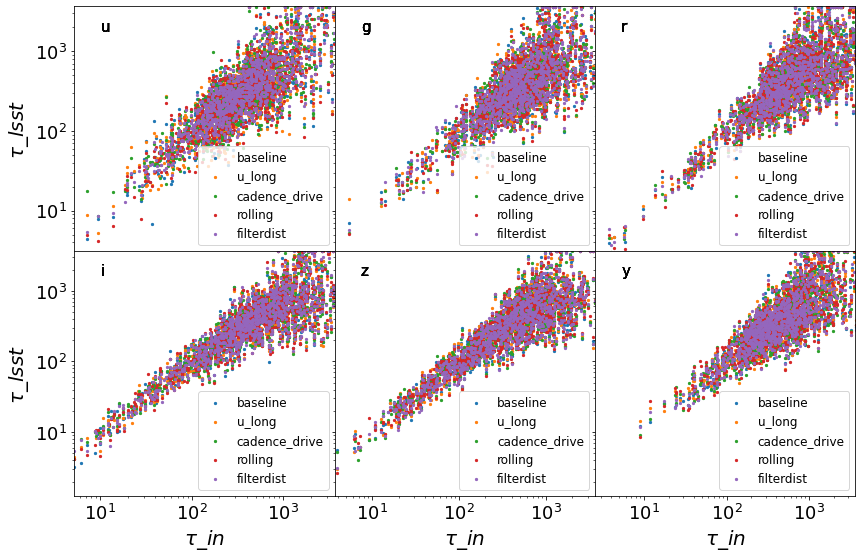

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(14,9),sharex='col',sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0})
band_list = ['u','g','r','i','z','y']
n = 0
for row in np.arange(2):
  for col in np.arange(3):
    ax = axs[row, col]
    for cad in cadence_list:
      sel_df = lsst_df[(lsst_df.cadence==cad)&(lsst_df.band==band_list[n])]
      ax.scatter(sel_df['tau_in'], sel_df['tau_lsst'], label = cad, s = 5)
      ax.text(0.1, 0.9, transform=ax.transAxes, s = band_list[n], fontsize = 15)
      ax.set_yscale('log') 
      ax.set_xscale('log') 
      ax.set_xticks([1e1, 1e2, 1e3])
      ax.set_yticks([1e1, 1e2, 1e3])
      ax.set_xlim(0, 3650)
      ax.set_ylim(0, 3650)
      ax.tick_params(axis="x", labelsize=18)
      ax.tick_params(axis="y", labelsize=18)
            
    ax.legend(loc = 'lower right', fontsize = 12)
    if row == 1:
      ax.set_xlabel(r'$\tau\_in$', fontsize = 20)
    if col == 0:
      ax.set_ylabel(r'$\tau\_lsst$', fontsize = 20)
    n += 1
plt.show()

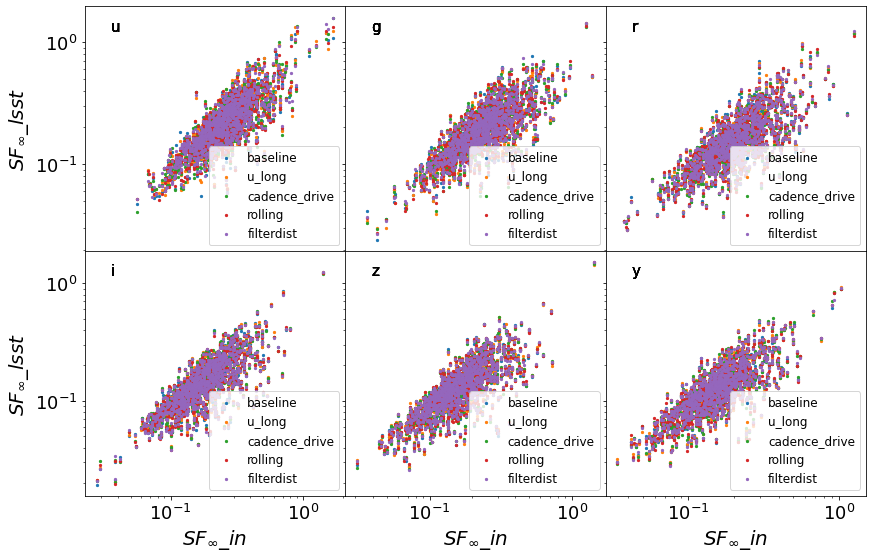

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(14,9),sharex='col',sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0})
band_list = ['u','g','r','i','z','y']
n = 0
for row in np.arange(2):
  for col in np.arange(3):
    ax = axs[row, col]
    for cad in cadence_list:
      sel_df = lsst_df[(lsst_df.cadence==cad)&(lsst_df.band==band_list[n])]
      ax.scatter(sel_df['sf_in'], sel_df['sf_lsst'], label = cad, s = 5)
      ax.text(0.1, 0.9, transform=ax.transAxes, s = band_list[n], fontsize = 15)
      ax.set_yscale('log') 
      ax.set_xscale('log') 
      # ax.set_xticks([1e-2, 1e-1, 1e0])
      # ax.set_xlim([1e-2, 2])
      # ax.set_ylim(0, 3650)
      ax.tick_params(axis="x", labelsize=18)
      ax.tick_params(axis="y", labelsize=18)
            
    ax.legend(loc = 'lower right', fontsize = 12)
    if row == 1:
      ax.set_xlabel(r'$SF_{\infty}\_in$', fontsize = 20)
    if col == 0:
      ax.set_ylabel(r'$SF_{\infty}\_lsst$', fontsize = 20)
    n += 1
plt.show()

In [ ]:
del prior_outputs, prior_z_mean, prior_z_log_sigma, d1_out

### DHO overdamped case plotting

In [ ]:
generative_model = tf.keras.models.load_model('drive/MyDrive/model_params/generative_model_1004_over_lsst_z')
inference_model = tf.keras.models.load_model('drive/MyDrive/model_params/inference_model_1004_over_lsst_z')

generative_model.summary()
inference_model.summary()

Model: "generative_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_input (InputLayer)            [(None, 3650, 2)]    0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 3650, 64)     6912        X_input[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 3650, 64)     18816       bidirectional[0][0]              
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 3650, 64)     18816       bidirectional_1[0][0]            
___________________________________________________________________________________

In [ ]:
# pass every object to the SRNN model, and gain the params, store them in a new .csv file
import pandas as pd
import json
import numpy as np

def normalization(data):
  return (data - np.mean(data))/np.std(data)

def preprocess_add_zeros(miss_mjd, miss_y, miss_yerr, full_mjd):
  new_miss_mjd = full_mjd.copy()
  new_miss_y = np.zeros(len(new_miss_mjd))
  new_miss_yerr = np.zeros(len(new_miss_mjd))

  n = 0
  for i in new_miss_mjd:
    if i in miss_mjd:
      i_idx = np.where(miss_mjd == i)
      new_miss_y[n] = miss_y[i_idx[0][0]] 
      new_miss_yerr[n] = miss_yerr[i_idx[0][0]]
    n +=1
  return new_miss_mjd, new_miss_y, new_miss_yerr


cadence_list = ['full','baseline', 'u_long', 'cadence_drive', 'rolling', 'filterdist']
band_list = ['u','g','r','i','z','y']


carma = 'over'
param_path = '/content/drive/Othercomputers/My MacBook Pro/SRNN_dataset/overDHO_400.csv'
param_set = pd.read_csv(param_path)

param_set = param_set.astype({'id': 'int'}).astype({'id': 'str'})
param_id = param_set['id'][80*6:160*6].values
# print(param_set)
input_dataset = list()
target_dataset = list()

id_list = []
count = 0
while count < len(param_id):
  obj_id = param_id[count]
  id_list.append(obj_id)
  filepath = '/content/drive/Othercomputers/My MacBook Pro/SRNN_dataset/lsst_obs_redshift/'+carma+'/'
  f = open(filepath+str(int(obj_id))+'.json', 'r')
  obj_info = json.load(f)
  for band in band_list:
    obj_band = obj_info[band]
    for cad in cadence_list:
      obj_cs = obj_band[cad]
      if cad == 'full':
        full_mjd = np.around(obj_cs['mjd'], decimals=0) # set decimal to 0
        full_y = obj_cs['y']
        real_mean = np.mean(full_y)
        full_y -= real_mean
      else:
        miss_mjd = np.around(obj_cs['mjd'], decimals=0)
        miss_y = obj_cs['y']
        miss_y -= real_mean
        miss_yerr = obj_cs['yerr']  
        new_miss_mjd, new_miss_y, new_miss_yerr = preprocess_add_zeros(miss_mjd, miss_y, miss_yerr, full_mjd)
        miss_sequence = [[t, y, yerr] for t, y, yerr in zip(new_miss_mjd, new_miss_y, new_miss_yerr)]
        input_dataset.append(miss_sequence)
  count += 6


input_dataset = np.array(input_dataset)

print(input_dataset.shape)



(2400, 3650, 3)


In [ ]:
prior_outputs, prior_z_mean, prior_z_log_sigma, d1_out = generative_model.predict(input_dataset[:,:,[1,2]])

In [ ]:
from eztao.ts import drw_fit, dho_fit
import math

def get_CARMA(carma, mjd, y, yerr):
  if carma == 'drw':
    best_fit_pred = drw_fit(mjd, y, yerr)
    sf = best_fit_pred[0]
    tau = best_fit_pred[1]
    return [sf, tau]
  else:
    best_fit_pred = dho_fit(mjd, y, yerr)
    alpha1, alpha2, beta0, beta1 = best_fit_pred
    sf = np.sqrt(2*(beta0**2 + alpha2*beta1**2)/(2*alpha1*alpha2))
    if carma == 'under':
      T_QPO,T_dQPO,tau_decay = get_DHO_underdamped_metric([alpha1, alpha2])
      return [T_QPO,T_dQPO,tau_decay, sf]
    else: 
      tau_rise,tau_decay = get_DHO_overdamping_metric([alpha1, alpha2])
      return [tau_rise,tau_decay, sf]

# DHO overdamping
def get_DHO_overdamping_metric(ar_overdamping):
    import numpy as np
    alpha_0 = ar_overdamping[0]
    alpha_1 = ar_overdamping[1]
    r1 = (-alpha_0 - np.sqrt(alpha_0**2 - 4*alpha_1))/2
    r2 = (-alpha_0 + np.sqrt(alpha_0**2 - 4*alpha_1))/2

    tau_rise = 1./(r2-r1)*np.log(abs(r1/r2))
    tau_decay = abs(1/max(r1,r2))
    return tau_rise,tau_decay

# DHO underdamped 
def get_DHO_underdamped_metric(ar_underdamped):
    import cmath
    alpha_1 = ar_underdamped[0]
    alpha_2 = ar_underdamped[1]
    T_QPO = 2*np.pi/np.sqrt(alpha_2)
    T_dQPO = 4*np.pi/np.sqrt(4*alpha_2 - alpha_1**2)
    tau_decay = 2/alpha_1
    return T_QPO,T_dQPO,tau_decay


cadence_list = ['baseline', 'u_long', 'cadence_drive', 'rolling', 'filterdist']
band_list = ['u','g','r','i','z','y']

all_param = list()

obj_num = int(prior_outputs.shape[0]/30)
n = 0
while n < prior_outputs.shape[0]:
  m = math.ceil(n/30)
  print(m)
  dict_id = {'id': id_list[m]}
  for band in band_list:
    ori_set = param_set[(param_set.id==id_list[m])&(param_set.band==band)]
    ori_param = get_DHO_overdamping_metric([ori_set['alpha1'].values[0], ori_set['alpha2'].values[0]])
    dict_band = {'band': band, 'rise_in': ori_param[0], 'decay_in':ori_param[1], 'sf_in':ori_set['SF'].values[0]}
    for cad in cadence_list:
      dict_cad = {'cadence': cad}
      pred_lc = prior_outputs[n].reshape(prior_outputs.shape[1])
      pred_lc -= np.mean(pred_lc)
      fit = get_CARMA('over', np.arange(len(pred_lc)), pred_lc, np.zeros(len(pred_lc)))
      srnn_param = {'rise_srnn': fit[0], 'decay_srnn':fit[1], 'sf_srnn':fit[2]}
      srnn_param.update(dict_band)
      srnn_param.update(dict_id)
      srnn_param.update(dict_cad)
      all_param.append(srnn_param)
      n += 1

srnn_df = pd.DataFrame(all_param)     


  
 


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


In [ ]:
srnn_df.to_csv('drive/MyDrive/srnn_over_z_1.csv')

In [ ]:
del prior_outputs, prior_z_mean, prior_z_log_sigma, d1_out, srnn_df

In [ ]:
# caculate the cadenced-light curve directly
import pandas as pd
import json
import numpy as np
from eztao.ts import drw_fit, dho_fit
import math

def get_CARMA(carma, mjd, y, yerr):
  if carma == 'drw':
    best_fit_pred = drw_fit(mjd, y, yerr)
    sf = best_fit_pred[0]
    tau = best_fit_pred[1]
    return [sf, tau]
  else:
    best_fit_pred = dho_fit(mjd, y, yerr)
    alpha1, alpha2, beta0, beta1 = best_fit_pred
    sf = np.sqrt(2*(beta0**2 + alpha2*beta1**2)/(2*alpha1*alpha2))
    if carma == 'under':
      T_QPO,T_dQPO,tau_decay = get_DHO_underdamped_metric([alpha1, alpha2])
      return [T_QPO,T_dQPO,tau_decay, sf]
    else: 
      tau_rise,tau_decay = get_DHO_overdamping_metric([alpha1, alpha2])
      return [tau_rise,tau_decay, sf]

# DHO overdamping
def get_DHO_overdamping_metric(ar_overdamping):
    import numpy as np
    alpha_0 = ar_overdamping[0]
    alpha_1 = ar_overdamping[1]
    r1 = (-alpha_0 - np.sqrt(alpha_0**2 - 4*alpha_1))/2
    r2 = (-alpha_0 + np.sqrt(alpha_0**2 - 4*alpha_1))/2

    tau_rise = 1./(r2-r1)*np.log(abs(r1/r2))
    tau_decay = abs(1/max(r1,r2))
    return tau_rise,tau_decay

    
cadence_list = ['baseline', 'u_long', 'cadence_drive', 'rolling', 'filterdist']
band_list = ['u','g','r','i','z','y']


carma = 'over'
param_path = '/content/drive/Othercomputers/My MacBook Pro/SRNN_dataset/overDHO_400.csv'
param_set = pd.read_csv(param_path)
id_list = list(set(param_set['id']))[200:400]


all_param = list()

for id in id_list:
  print(id)
  dict_id = {'id': id}
  filepath = '/content/drive/Othercomputers/My MacBook Pro/SRNN_dataset/lsst_obs_identical/'+carma+'/'
  f = open(filepath+str(int(id))+'.json', 'r')
  obj_info = json.load(f)
  for band in band_list:
    ori_set = param_set[(param_set.id==id)&(param_set.band==band)]
    ori_param = get_DHO_overdamping_metric([ori_set['alpha1'].values[0], ori_set['alpha2'].values[0]])
    dict_band = {'band': band, 'rise_in': ori_param[0], 'decay_in':ori_param[1], 'sf_in':ori_set['SF'].values[0]}
    obj_band = obj_info[band]
    for cad in cadence_list:
      dict_cad = {'cadence': cad}
      obj_cs = obj_band[cad]
      miss_mjd = np.around(obj_cs['mjd'], decimals=0)
      miss_y = obj_cs['y']
      miss_y -= np.mean(miss_y)
      miss_yerr = obj_cs['yerr']
      fit = get_CARMA('over', miss_mjd, miss_y, miss_yerr)
      lsst_param = {'rise_lsst': fit[0], 'decay_lsst':fit[1], 'sf_lsst':fit[2]}
      lsst_param.update(dict_band)
      lsst_param.update(dict_id)
      lsst_param.update(dict_cad)
      all_param.append(lsst_param)

lsst_df = pd.DataFrame(all_param) 



In [ ]:

lsst_df

rise_lsst  decay_lsst   sf_lsst  ...     sf_in       id        cadence
0           NaN         NaN  0.103833  ...  0.157213  74740.0       baseline
1      4.696880   52.434601  0.104986  ...  0.157213  74740.0         u_long
2     13.382538  170.797564  0.113172  ...  0.157213  74740.0  cadence_drive
3      7.192261   47.084458  0.099772  ...  0.157213  74740.0        rolling
4           NaN         NaN  0.122481  ...  0.157213  74740.0     filterdist
...         ...         ...       ...  ...       ...      ...            ...
5995   0.346411  444.983722  0.219344  ...  0.392929   2047.0       baseline
5996   0.161709  497.829109  0.225278  ...  0.392929   2047.0         u_long
5997   0.304089  416.197517  0.214102  ...  0.392929   2047.0  cadence_drive
5998   1.232282  623.020387  0.228788  ...  0.392929   2047.0        rolling
5999  38.001436  547.782112  0.217224  ...  0.392929   2047.0     filterdist

[6000 rows x 9 columns]

In [ ]:
lsst_df.to_csv('drive/MyDrive/lsst_over_3.csv') #104 obj


### Plotting for DHO-over

In [ ]:
srnn_df = pd.read_csv('drive/MyDrive/srnn_over_1.csv')

for i in np.arange(2,9):
  df2 = pd.read_csv('drive/MyDrive/srnn_over_'+str(i)+'.csv')
  srnn_df = pd.concat([srnn_df, df2])
  del df2
srnn_df.to_csv('drive/MyDrive/srnn_over_all.csv')

In [ ]:
srnn_df

Unnamed: 0  rise_srnn   decay_srnn  ...     sf_in       id        cadence
0              0   0.638841  1228.756999  ...  0.255996  75780.0       baseline
1              1   0.281995  1080.115684  ...  0.255996  75780.0         u_long
2              2   0.429467  1075.811740  ...  0.255996  75780.0  cadence_drive
3              3   0.472127  1092.281198  ...  0.255996  75780.0        rolling
4              4   0.245974  1220.648745  ...  0.255996  75780.0     filterdist
...          ...        ...          ...  ...       ...      ...            ...
1495        1495   0.089661  1946.746870  ...  0.392929   2047.0       baseline
1496        1496   1.913063  2597.724441  ...  0.392929   2047.0         u_long
1497        1497   0.101783  1935.868946  ...  0.392929   2047.0  cadence_drive
1498        1498   0.353765  2276.635506  ...  0.392929   2047.0        rolling
1499        1499   0.132538  1952.052769  ...  0.392929   2047.0     filterdist

[12000 rows x 10 columns]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  app.launch_new_instance()


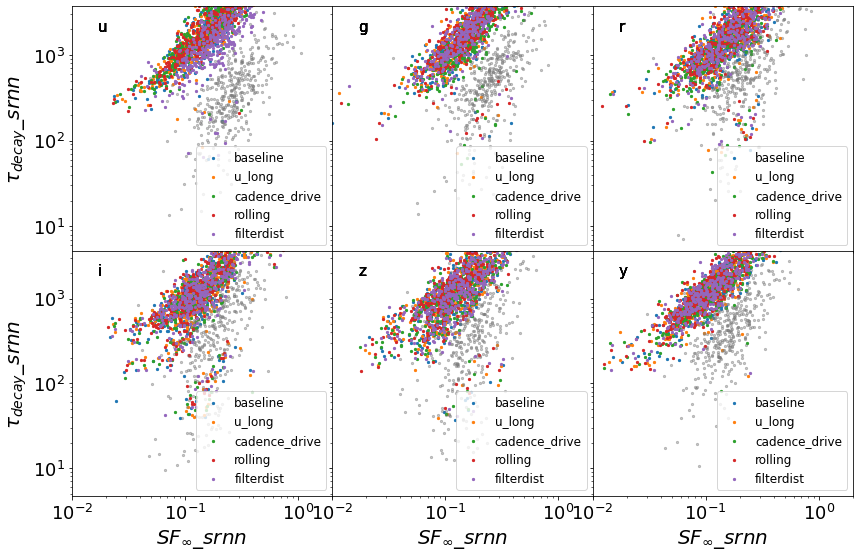

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(14,9),sharex='col',sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0})
band_list = ['u','g','r','i','z','y']
cadence_list = ['baseline', 'u_long', 'cadence_drive', 'rolling', 'filterdist']
n = 0
for row in np.arange(2):
  for col in np.arange(3):
    ax = axs[row, col]
    for cad in cadence_list:
      sel_df = srnn_df[(srnn_df.cadence==cad)&(srnn_df.band==band_list[n])]
      ax.scatter(sel_df['sf_in'], sel_df['decay_in'], color = 'grey', alpha = 0.1, s = 5)
      ax.scatter(sel_df['sf_srnn'], sel_df['decay_srnn'], label = cad, s = 5)
      ax.text(0.1, 0.9, transform=ax.transAxes, s = band_list[n], fontsize = 15)
      ax.set_yscale('log') 
      ax.set_xscale('log') 
      ax.set_xlim([1e-2, 2])
      ax.set_ylim(0, 3650)
      ax.tick_params(axis="x", labelsize=18)
      ax.tick_params(axis="y", labelsize=18)
            
    ax.legend(loc = 'lower right', fontsize = 12)
    if row == 1:
      ax.set_xlabel(r'$SF_{\infty}\_srnn$', fontsize = 20)
    if col == 0:
      ax.set_ylabel(r'$\tau_{decay}\_srnn$', fontsize = 20)
    n += 1
plt.show()

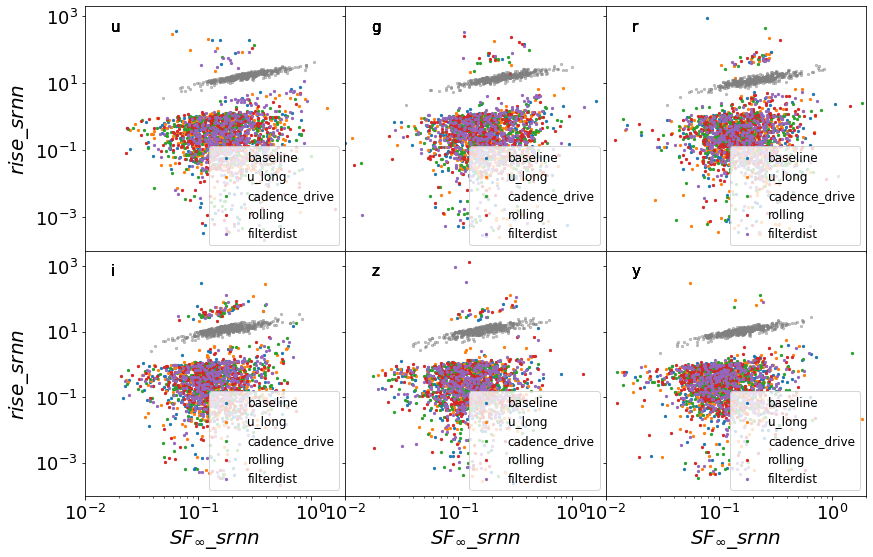

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(14,9),sharex='col',sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0})
band_list = ['u','g','r','i','z','y']
cadence_list = ['baseline', 'u_long', 'cadence_drive', 'rolling', 'filterdist']
n = 0
for row in np.arange(2):
  for col in np.arange(3):
    ax = axs[row, col]
    for cad in cadence_list:
      sel_df = srnn_df[(srnn_df.cadence==cad)&(srnn_df.band==band_list[n])]
      ax.scatter(sel_df['sf_in'], sel_df['rise_in'], color = 'grey', alpha = 0.1, s = 5)
      ax.scatter(sel_df['sf_srnn'], sel_df['rise_srnn'], label = cad, s = 5)
      ax.text(0.1, 0.9, transform=ax.transAxes, s = band_list[n], fontsize = 15)
      ax.set_yscale('log') 
      ax.set_xscale('log') 
      ax.set_xlim([1e-2, 2])
      # ax.set_ylim(0, 3650)
      ax.tick_params(axis="x", labelsize=18)
      ax.tick_params(axis="y", labelsize=18)
            
    ax.legend(loc = 'lower right', fontsize = 12)
    if row == 1:
      ax.set_xlabel(r'$SF_{\infty}\_srnn$', fontsize = 20)
    if col == 0:
      ax.set_ylabel(r'$rise\_srnn$', fontsize = 20)
    n += 1
plt.show()

### DHO underdamped case plotting

In [ ]:
generative_model = tf.keras.models.load_model('drive/MyDrive/model_params/generative_model_1004_under_lsst_z')
inference_model = tf.keras.models.load_model('drive/MyDrive/model_params/inference_model_1004_under_lsst_z')

generative_model.summary()
inference_model.summary()

Model: "generative_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_input (InputLayer)            [(None, 3650, 1)]    0                                            
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) (None, 3650, 64)     6720        X_input[0][0]                    
__________________________________________________________________________________________________
bidirectional_8 (Bidirectional) (None, 3650, 64)     18816       bidirectional_7[0][0]            
__________________________________________________________________________________________________
bidirectional_9 (Bidirectional) (None, 3650, 64)     18816       bidirectional_8[0][0]            
___________________________________________________________________________________

In [ ]:
# pass every object to the SRNN model, and gain the params, store them in a new .csv file
import pandas as pd
import json
import numpy as np

def normalization(data):
  return (data - np.mean(data))/np.std(data)

def preprocess_add_zeros(miss_mjd, miss_y, miss_yerr, full_mjd):
  new_miss_mjd = full_mjd.copy()
  new_miss_y = np.zeros(len(new_miss_mjd))
  new_miss_yerr = np.zeros(len(new_miss_mjd))

  n = 0
  for i in new_miss_mjd:
    if i in miss_mjd:
      i_idx = np.where(miss_mjd == i)
      new_miss_y[n] = miss_y[i_idx[0][0]] 
      new_miss_yerr[n] = miss_yerr[i_idx[0][0]]
    n +=1
  return new_miss_mjd, new_miss_y, new_miss_yerr


cadence_list = ['full','baseline', 'u_long', 'cadence_drive', 'rolling', 'filterdist']
band_list = ['u','g','r','i','z','y']


carma = 'under'
param_path = '/content/drive/Othercomputers/My MacBook Pro/SRNN_dataset/underDHO_1075.csv'
param_set = pd.read_csv(param_path)

param_set = param_set.astype({'id': 'int'}).astype({'id': 'str'})
param_id = param_set['id'][160*6:240*6].values
# print(param_set)
input_dataset = list()
target_dataset = list()

id_list = []
count = 0
while count < len(param_id):
  obj_id = param_id[count]
  id_list.append(obj_id)
  filepath = '/content/drive/Othercomputers/My MacBook Pro/SRNN_dataset/lsst_obs_redshift/'+carma+'/'
  f = open(filepath+str(int(obj_id))+'.json', 'r')
  obj_info = json.load(f)
  for band in band_list:
    obj_band = obj_info[band]
    for cad in cadence_list:
      obj_cs = obj_band[cad]
      if cad == 'full':
        full_mjd = np.around(obj_cs['mjd'], decimals=0) # set decimal to 0
        full_y = obj_cs['y']
        real_mean = np.mean(full_y)
        full_y -= real_mean
      else:
        miss_mjd = np.around(obj_cs['mjd'], decimals=0)
        miss_y = obj_cs['y']
        miss_y -= real_mean
        miss_yerr = obj_cs['yerr']  
        new_miss_mjd, new_miss_y, new_miss_yerr = preprocess_add_zeros(miss_mjd, miss_y, miss_yerr, full_mjd)
        miss_sequence = [[y] for y in new_miss_y]
        input_dataset.append(miss_sequence)
  count += 6


input_dataset = np.array(input_dataset)

print(input_dataset.shape)



(2400, 3650, 1)


In [ ]:
prior_outputs, prior_z_mean, prior_z_log_sigma, d1_out = generative_model.predict(input_dataset[:,:,[0]])

In [ ]:
from eztao.ts import drw_fit, dho_fit
import math

def get_CARMA(carma, mjd, y, yerr):
  if carma == 'drw':
    best_fit_pred = drw_fit(mjd, y, yerr)
    sf = best_fit_pred[0]
    tau = best_fit_pred[1]
    return [sf, tau]
  else:
    best_fit_pred = dho_fit(mjd, y, yerr)
    alpha1, alpha2, beta0, beta1 = best_fit_pred
    sf = np.sqrt(2*(beta0**2 + alpha2*beta1**2)/(2*alpha1*alpha2))
    if carma == 'under':
      T_QPO,T_dQPO,tau_decay = get_DHO_underdamped_metric([alpha1, alpha2])
      return [T_QPO,T_dQPO,tau_decay, sf]
    else: 
      tau_rise,tau_decay = get_DHO_overdamping_metric([alpha1, alpha2])
      return [tau_rise,tau_decay, sf]

# DHO overdamping
def get_DHO_overdamping_metric(ar_overdamping):
    import numpy as np
    alpha_0 = ar_overdamping[0]
    alpha_1 = ar_overdamping[1]
    r1 = (-alpha_0 - np.sqrt(alpha_0**2 - 4*alpha_1))/2
    r2 = (-alpha_0 + np.sqrt(alpha_0**2 - 4*alpha_1))/2

    tau_rise = 1./(r2-r1)*np.log(abs(r1/r2))
    tau_decay = abs(1/max(r1,r2))
    return tau_rise,tau_decay

# DHO underdamped 
def get_DHO_underdamped_metric(ar_underdamped):
    import cmath
    alpha_1 = ar_underdamped[0]
    alpha_2 = ar_underdamped[1]
    T_QPO = 2*np.pi/np.sqrt(alpha_2)
    T_dQPO = 4*np.pi/np.sqrt(4*alpha_2 - alpha_1**2)
    tau_decay = 2/alpha_1
    return T_QPO,T_dQPO,tau_decay


cadence_list = ['baseline', 'u_long', 'cadence_drive', 'rolling', 'filterdist']
band_list = ['u','g','r','i','z','y']

all_param = list()
# all_param = np.empty(prior_outputs.shape[0],11)

obj_num = int(prior_outputs.shape[0]/30)
n = 0
while n < prior_outputs.shape[0]:
  m = math.ceil(n/30)
  print(m)
  dict_id = {'id': id_list[m]}
  for band in band_list:
    ori_set = param_set[(param_set.id==id_list[m])&(param_set.band==band)]
    ori_param = get_DHO_underdamped_metric([ori_set['alpha1'].values[0], ori_set['alpha2'].values[0]])
    dict_band = {'band': band, 'qpo_in': ori_param[0], 'dqpo_in':ori_param[1], 'decay_in':ori_param[2], 'sf_in':ori_set['SF'].values[0]}
    for cad in cadence_list:
      dict_cad = {'cadence': cad}
      pred_lc = prior_outputs[n].reshape(prior_outputs.shape[1])
      pred_lc -= np.mean(pred_lc)
      fit = get_CARMA('under', np.arange(len(pred_lc)), pred_lc, np.zeros(len(pred_lc)))
      srnn_param = {'qpo_srnn': fit[0], 'dqpo_srnn':fit[1], 'decay_srnn':fit[2], 'sf_srnn':fit[3]}
      srnn_param.update(dict_band)
      srnn_param.update(dict_id)
      srnn_param.update(dict_cad)
      all_param.append(srnn_param)
      n += 1

srnn_df = pd.DataFrame(all_param)     


  
 


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


In [ ]:
srnn_df.to_csv('drive/MyDrive/srnn_under_z_2.csv')

In [ ]:
del srnn_df, prior_outputs, prior_z_mean, prior_z_log_sigma, d1_out

In [ ]:
# caculate the cadenced-light curve directly
import pandas as pd
import json
import numpy as np
from eztao.ts import drw_fit, dho_fit
import math

def get_CARMA(carma, mjd, y, yerr):
  if carma == 'drw':
    best_fit_pred = drw_fit(mjd, y, yerr)
    sf = best_fit_pred[0]
    tau = best_fit_pred[1]
    return [sf, tau]
  else:
    best_fit_pred = dho_fit(mjd, y, yerr)
    alpha1, alpha2, beta0, beta1 = best_fit_pred
    sf = np.sqrt(2*(beta0**2 + alpha2*beta1**2)/(2*alpha1*alpha2))
    if carma == 'under':
      T_QPO,T_dQPO,tau_decay = get_DHO_underdamped_metric([alpha1, alpha2])
      return [T_QPO,T_dQPO,tau_decay, sf]
    else: 
      tau_rise,tau_decay = get_DHO_overdamping_metric([alpha1, alpha2])
      return [tau_rise,tau_decay, sf]


# DHO underdamped 
def get_DHO_underdamped_metric(ar_underdamped):
    import cmath
    alpha_1 = ar_underdamped[0]
    alpha_2 = ar_underdamped[1]
    T_QPO = 2*np.pi/np.sqrt(alpha_2)
    T_dQPO = 4*np.pi/np.sqrt(4*alpha_2 - alpha_1**2)
    tau_decay = 2/alpha_1
    return T_QPO,T_dQPO,tau_decay

    
cadence_list = ['baseline', 'u_long', 'cadence_drive', 'rolling', 'filterdist']
band_list = ['u','g','r','i','z','y']


carma = 'under'
param_path = '/content/drive/Othercomputers/My MacBook Pro/SRNN_dataset/underDHO_1075.csv.csv'
param_set = pd.read_csv(param_path)
id_list = list(set(param_set['id']))[0:400]


all_param = list()

for id in id_list:
  print(id)
  dict_id = {'id': id}
  filepath = '/content/drive/Othercomputers/My MacBook Pro/SRNN_dataset/lsst_obs_identical/'+carma+'/'
  f = open(filepath+str(int(id))+'.json', 'r')
  obj_info = json.load(f)
  for band in band_list:
    ori_set = param_set[(param_set.id==id)&(param_set.band==band)]
    ori_param = get_DHO_underdamped_metric([ori_set['alpha1'].values[0], ori_set['alpha2'].values[0]])
    dict_band = {'band': band, 'qpo_in': ori_param[0], 'dqpo_in':ori_param[1], 'decay_in':ori_param[2], 'sf_in':ori_set['SF'].values[0]}
    # dict_band = {'band': band, 'rise_in': ori_param[0], 'decay_in':ori_param[1], 'sf_in':ori_set['SF'].values[0]}
    obj_band = obj_info[band]
    for cad in cadence_list:
      dict_cad = {'cadence': cad}
      obj_cs = obj_band[cad]
      miss_mjd = np.around(obj_cs['mjd'], decimals=0)
      miss_y = obj_cs['y']
      miss_y -= np.mean(miss_y)
      miss_yerr = obj_cs['yerr']
      fit = get_CARMA('over', miss_mjd, miss_y, miss_yerr)
      lsst_param = {'qpo_lsst': fit[0], 'dqpo_lsst':fit[1], 'decay_lsst':fit[2], 'sf_lsst':fit[3]}
      lsst_param.update(dict_band)
      lsst_param.update(dict_id)
      lsst_param.update(dict_cad)
      all_param.append(lsst_param)

lsst_df = pd.DataFrame(all_param) 



In [ ]:
srnn_df = pd.read_csv('drive/MyDrive/srnn_over_z_0.csv')

for i in np.arange(1,5):
  df2 = pd.read_csv('drive/MyDrive/srnn_over_z_'+str(i)+'.csv')
  srnn_df = pd.concat([srnn_df, df2])
  del df2
srnn_df.to_csv('drive/MyDrive/srnn_over_redshift_all.csv')

In [ ]:
len(list(set(srnn_df['id'])))

400

In [ ]:
lsst_df = pd.read_csv('drive/MyDrive/lsst_under_z_0.csv')
df2 = pd.read_csv('drive/MyDrive/lsst_under_z_1.csv')
lsst_df = pd.concat([lsst_df, df2])
lsst_df.to_csv('drive/MyDrive/lsst_under_redshift_all.csv')

In [ ]:
len(list(set(lsst_df['id'])))

400

# DRW with time dilation


In [ ]:
srnn_df = pd.read_csv('drive/MyDrive/srnn_drw_redshift_all.csv')
lsst_df = pd.read_csv('drive/MyDrive/lsst_drw_all_redshift.csv')

Unnamed: 0   sf_lsst    tau_lsst  ... redshift       id        cadence
0               0  0.204121  224.666036  ...   0.6125    190.0       baseline
1               1  0.185969  215.975880  ...   0.6125    190.0         u_long
2               2  0.185835  175.641734  ...   0.6125    190.0  cadence_drive
3               3  0.191082  155.596972  ...   0.6125    190.0        rolling
4               4  0.185912  150.408781  ...   0.6125    190.0     filterdist
...           ...       ...         ...  ...      ...      ...            ...
11995       11995  0.018912  276.543891  ...   2.0021  76485.0       baseline
11996       11996  0.019603  254.113302  ...   2.0021  76485.0         u_long
11997       11997  0.020018  328.540680  ...   2.0021  76485.0  cadence_drive
11998       11998  0.018567  351.718255  ...   2.0021  76485.0        rolling
11999       11999  0.018795  227.200802  ...   2.0021  76485.0     filterdist

[12000 rows x 9 columns]